<a href="https://colab.research.google.com/github/4GeeksAcademy/ReviewSense-Comparativa-de-modelos-de-sentimiento-en-datos-de-hoteles/blob/main/Final_Project_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install kagglehub
!pip install wordcloud
!pip install nltk
!pip install torch -qq
!pip install pyarrow -qq
!pip install transformers accelerate evaluate datasets -qq
import pandas as pd
import os
import kagglehub
import ast
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import evaluate
from datasets import Dataset
from tqdm.notebook import tqdm
import joblib
from torch.utils.data import DataLoader
import gc
import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


Generate Kaggle API Token:

Go to Kaggle.

Log in to your account.

Click on your profile picture in the top right corner and select "My Account".

Scroll down to the "API" section and click "Create New API Token". This will download a kaggle.json file to your computer.

Upload kaggle.json to Colab:

In your Colab notebook, run the following cell. It will prompt you to upload the kaggle.json file.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanreveron","key":"973bcdc3fa82cc71368a866d7fed49ba"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

Dataset URL: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe
License(s): CC0-1.0
  0% 0.00/45.1M [00:00<?, ?B/s]
100% 45.1M/45.1M [00:00<00:00, 886MB/s]


In [ ]:
!unzip 515k-hotel-reviews-data-in-europe.zip

Archive:  515k-hotel-reviews-data-in-europe.zip
  inflating: Hotel_Reviews.csv       


In [ ]:
# Define the path to unzipped CSV file
file_path = 'Hotel_Reviews.csv'

# Load the CSV into a Pandas DataFrame
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("DataFrame loaded successfully!")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataFrame Info (columns, non-null counts, dtypes):")
    df.info()

    print(f"\nTotal rows in DataFrame: {df.shape[0]}")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure you unzipped the file correctly and it's in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")

DataFrame loaded successfully!

First 5 rows:
                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1           

In [ ]:
# Show the number of rows and columns (DataFrame shape)
print("DataFrame Shape (Rows, Columns):")
print(df.shape)

# Show the names of all columns
print("\nDataFrame Column Names:")
print(df.columns.tolist()) # .tolist() makes it print as a neat list

DataFrame Shape (Rows, Columns):
(515738, 17)

DataFrame Column Names:
['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags', 'days_since_review', 'lat', 'lng']


In [ ]:
print("\nDetailed Missing Values Count:")
print(df.isnull().sum())


Detailed Missing Values Count:
Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64


In [ ]:
print("\nNumber of Duplicate Rows:")
num_duplicates = df.duplicated().sum()
print(f"Found {num_duplicates} duplicate rows.")

if num_duplicates > 0:
    print("Removing duplicate rows...")
    df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New DataFrame shape: {df.shape}")
else:
    print("No duplicate rows found.")


Number of Duplicate Rows:
Found 526 duplicate rows.
Removing duplicate rows...
Duplicates removed. New DataFrame shape: (515212, 17)


In [ ]:
df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')

# Concatenate positive and negative reviews to form a single 'Review_Text' column.
# Add a space in between if both are present.
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']

# Remove leading/trailing spaces and handle multiple spaces
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Drop the temporary clean columns if no longer needed
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)

In [ ]:
print(df.shape)

(515212, 18)


In [ ]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Review_Text
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Only the park outside of the hotel was beautif...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,No real complaints the hotel was great great l...
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Location was good and staff were ok It is cute...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Great location in nice surroundings the bar an...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Amazing location and building Romantic setting...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515212 non-null  object 
 1   Additional_Number_of_Scoring                515212 non-null  int64  
 2   Review_Date                                 515212 non-null  object 
 3   Average_Score                               515212 non-null  float64
 4   Hotel_Name                                  515212 non-null  object 
 5   Reviewer_Nationality                        515212 non-null  object 
 6   Negative_Review                             515212 non-null  object 
 7   Review_Total_Negative_Word_Counts           515212 non-null  int64  
 8   Total_Number_of_Reviews                     515212 non-null  int64  
 9   Positive_Review                             515212 non-null  object 
 10  R

In [ ]:
df.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515212.000000,515212.000000,515212.000000,515212.000000,515212.000000,515212.000000,515212.000000,511944.000000,511944.000000
mean,498.416021,8.397767,18.540822,2744.698889,17.778256,7.164895,8.395532,49.443040,2.824222
std,500.668595,0.547952,29.693991,2318.090821,21.804541,11.039354,1.637467,3.468029,4.581637
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214277,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [ ]:
# Displaying top 20 unique hotel names, as there will be many
print(df['Hotel_Name'].value_counts().head(20))
print(f"\nTotal unique hotels: {df['Hotel_Name'].nunique()}")

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3577
DoubleTree by Hilton Hotel London Tower of London    3212
Grand Royale London Hyde Park                        2958
Holiday Inn London Kensington                        2768
Hilton London Metropole                              2628
Millennium Gloucester Hotel London                   2565
Intercontinental London The O2                       2551
Park Grand Paddington Court                          2288
Hilton London Wembley                                2227
Park Plaza County Hall London                        2223
Blakemore Hyde Park                                  2178
Park Plaza London Riverbank                          2167
M by Montcalm Shoreditch London Tech City            2155
DoubleTree by Hilton London Docklands Riverside      2147
St 

In [ ]:
# Displaying top 20 unique nationalities for brevity, as there might be many
print(df['Reviewer_Nationality'].value_counts().head(20))
print(f"\nTotal unique nationalities: {df['Reviewer_Nationality'].nunique()}")

Reviewer_Nationality
United Kingdom               245110
United States of America      35349
Australia                     21648
Ireland                       14814
United Arab Emirates          10229
Saudi Arabia                   8940
Netherlands                    8757
Switzerland                    8669
Germany                        7929
Canada                         7883
France                         7265
Israel                         6601
Italy                          6113
Belgium                        6024
Turkey                         5440
Kuwait                         4915
Spain                          4735
Romania                        4548
Russia                         3898
South Africa                   3816
Name: count, dtype: int64

Total unique nationalities: 227


In [ ]:
# The 'Tags' column is a string containing multiple tags separated by commas.
# To get truly unique individual tags, we need to process this column.
# Let's show a few raw examples first.
print("\nExample raw 'Tags' entries:")
print(df['Tags'].head().tolist())


Example raw 'Tags' entries:
["[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']", "[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 4 nights ']", "[' Leisure trip ', ' Family with young children ', ' Duplex Double Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']", "[' Leisure trip ', ' Solo traveler ', ' Duplex Double Room ', ' Stayed 3 nights ']", "[' Leisure trip ', ' Couple ', ' Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"]


In [ ]:
# To get actual individual unique tags, we need to split and explode the strings
# This process might be computationally intensive for very large datasets if not optimized.
# Let's get a sample of common tags first
# This is a good step for later preprocessing, just showing a few unique combinations for now.
print(f"\nTotal unique combinations of tags: {df['Tags'].nunique()}")
print("Top 100 most frequent tag combinations:")
df['Tags'].value_counts().head(100)


Total unique combinations of tags: 55242
Top 100 most frequent tag combinations:


,count
Tags,
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",5101
"[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",4931
"[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",4362
"[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",3986
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",3291
...,...
"[' Leisure trip ', ' Couple ', ' Standard Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",576
"[' Leisure trip ', ' Couple ', ' Deluxe Double ', ' Stayed 1 night ', ' Submitted from a mobile device ']",575
"[' Leisure trip ', ' Solo traveler ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",570


In [ ]:
# --- Analyze the Reviewer_Score distribution ---
print("\n--- Distribution of 'Reviewer_Score' ---")
print(df['Reviewer_Score'].value_counts().sort_index())
print(f"\nMean Reviewer Score: {df['Reviewer_Score'].mean():.2f}")
print(f"Median Reviewer Score: {df['Reviewer_Score'].median():.2f}")
print(f"Min Reviewer Score: {df['Reviewer_Score'].min():.2f}")
print(f"Max Reviewer Score: {df['Reviewer_Score'].max():.2f}")


--- Distribution of 'Reviewer_Score' ---
Reviewer_Score
2.5       2192
2.9       1583
3.0         37
3.1          8
3.3       2765
3.5         79
3.8       4035
4.0         84
4.2       5089
4.4         12
4.5        122
4.6       6226
5.0       8408
5.4       9518
5.5        227
5.6         17
5.8      12014
6.0        253
6.3      14909
6.5        345
6.7      18765
6.9         29
7.0        410
7.1      24837
7.5      34831
7.9      33062
8.0        505
8.1         39
8.3      41090
8.5        508
8.8      46386
9.0        646
9.2      58526
9.4         63
9.5        724
9.6      71110
10.0    115758
Name: count, dtype: int64

Mean Reviewer Score: 8.40
Median Reviewer Score: 8.80
Min Reviewer Score: 2.50
Max Reviewer Score: 10.00


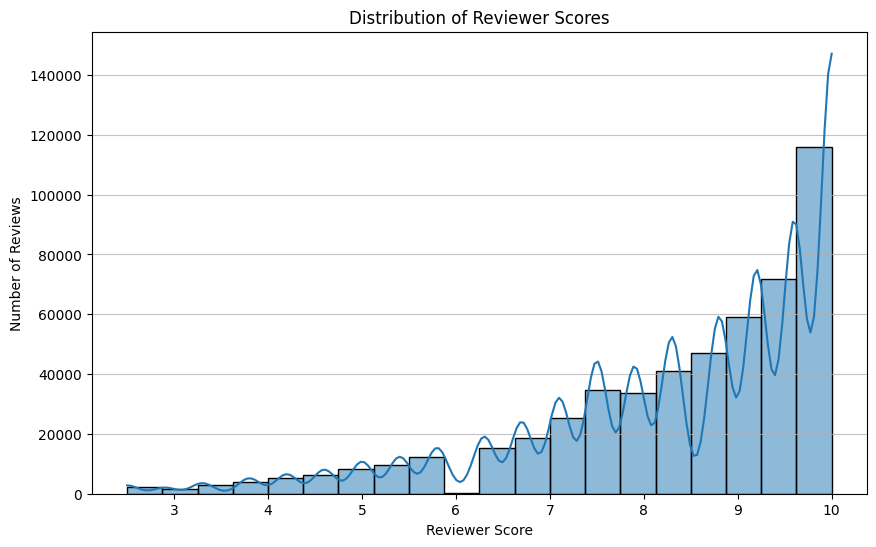

In [ ]:
# We can also visualize this distribution with a histogram
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['Reviewer_Score'], bins=20, kde=True)
plt.title('Distribution of Reviewer Scores')
plt.xlabel('Reviewer Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Step 1: Convert 'Tags' string to an actual list of strings ---

In [ ]:
# Use ast.literal_eval to safely parse the string representation of a list
def parse_tags_string(tags_str):
    try:
        # Evaluate the string as a Python literal (list in this case)
        # Then strip whitespace from each tag
        return [tag.strip() for tag in ast.literal_eval(tags_str)]
    except (ValueError, SyntaxError):
        return [] # Return empty list if parsing fails for any reason

df['Tags_List'] = df['Tags'].apply(parse_tags_string)

print("\n--- Example of 'Tags_List' after parsing ---")
print(df[['Tags', 'Tags_List']].head())


--- Example of 'Tags_List' after parsing ---
                                                Tags  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...   
2  [' Leisure trip ', ' Family with young childre...   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...   

                                           Tags_List  
0  [Leisure trip, Couple, Duplex Double Room, Sta...  
1  [Leisure trip, Couple, Duplex Double Room, Sta...  
2  [Leisure trip, Family with young children, Dup...  
3  [Leisure trip, Solo traveler, Duplex Double Ro...  
4  [Leisure trip, Couple, Suite, Stayed 2 nights,...  


# --- Step 2: Define functions to extract specific information ---


In [ ]:
def extract_group_size(tags_list):
    group_size_keywords = {
        'Couple': 'Couple',
        'Solo traveler': 'Solo',
        'Family with young children': 'Family',
        'Family with older children': 'Family',
        'Group': 'Group',
        'Friends': 'Friends',
        'Business traveler': 'Business'
    }
    for tag in tags_list:
        for keyword, category in group_size_keywords.items():
            if keyword in tag:
                return category
    return 'Unknown Group' # Default if no match is found

def extract_room_type(tags_list):
    # Prioritize more specific room types first
    room_type_keywords = [
        'Duplex Double Room', 'Family Room', 'King Room', 'Queen Room',
        'Superior Double Room', 'Deluxe Double Room', 'Standard Double Room',
        'Twin Room', 'Double Room', 'Single Room', 'Triple Room', 'Quadruple Room',
        'Suite', 'Apartment', 'Studio', 'Executive Room', 'Club Room',
        'Standard Room', 'Superior Room', 'Deluxe Room', 'Classic Room'
    ]
    for tag in tags_list:
        for keyword in room_type_keywords:
            if keyword in tag:
                return keyword.replace(' Room', '').strip() # Clean up ' Room' for consistency
    return 'Unknown Room Type' # Default if no match

def extract_length_of_stay(tags_list):
    for tag in tags_list:
        match = re.search(r'Stayed (\d+) night(?:s)?', tag)
        if match:
            return int(match.group(1))
    return None # Return None if length of stay isn't found

def extract_trip_type(tags_list):
    trip_type_keywords = {
        'Leisure trip': 'Leisure',
        'Business trip': 'Business'
    }
    for tag in tags_list:
        for keyword, category in trip_type_keywords.items():
            if keyword in tag:
                return category
    return 'Unknown Trip Type'

def extract_submission_device(tags_list):
    for tag in tags_list:
        if 'Submitted from a mobile device' in tag:
            return 'Mobile'
        elif 'Submitted from a desktop device' in tag: # Assuming this tag might exist, though less common
            return 'Desktop'
    return 'Unknown Device'

# --- Step 3: Apply the extraction functions to create new columns ---

In [ ]:
df['group_size'] = df['Tags_List'].apply(extract_group_size)
df['room_type'] = df['Tags_List'].apply(extract_room_type)
df['length_of_stay'] = df['Tags_List'].apply(extract_length_of_stay)
df['trip_type'] = df['Tags_List'].apply(extract_trip_type)
df['submission_device'] = df['Tags_List'].apply(extract_submission_device)


print("\n--- DataFrame with new extracted columns (head) ---")
print(df[['Tags', 'group_size', 'room_type', 'length_of_stay', 'trip_type', 'submission_device']].head())

print("\n--- Value Counts for New Columns ---")
print("\nGroup Size Distribution:")
print(df['group_size'].value_counts())

print("\nRoom Type Distribution (Top 20):")
print(df['room_type'].value_counts().head(20))

print("\nLength of Stay Distribution (Top 10):")
print(df['length_of_stay'].value_counts().head(10))

print("\nTrip Type Distribution:")
print(df['trip_type'].value_counts())

print("\nSubmission Device Distribution:")
print(df['submission_device'].value_counts())

print("\nDataFrame Info after adding new columns:")
df.info()


--- DataFrame with new extracted columns (head) ---
                                                Tags group_size  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...     Couple   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...     Couple   
2  [' Leisure trip ', ' Family with young childre...     Family   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...       Solo   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...     Couple   

       room_type  length_of_stay trip_type submission_device  
0  Duplex Double             6.0   Leisure    Unknown Device  
1  Duplex Double             4.0   Leisure    Unknown Device  
2  Duplex Double             3.0   Leisure            Mobile  
3  Duplex Double             3.0   Leisure    Unknown Device  
4          Suite             2.0   Leisure            Mobile  

--- Value Counts for New Columns ---

Group Size Distribution:
group_size
Couple           252005
Solo             108431
Family            87295
Group             6


--- Histograms for Numerical Features ---


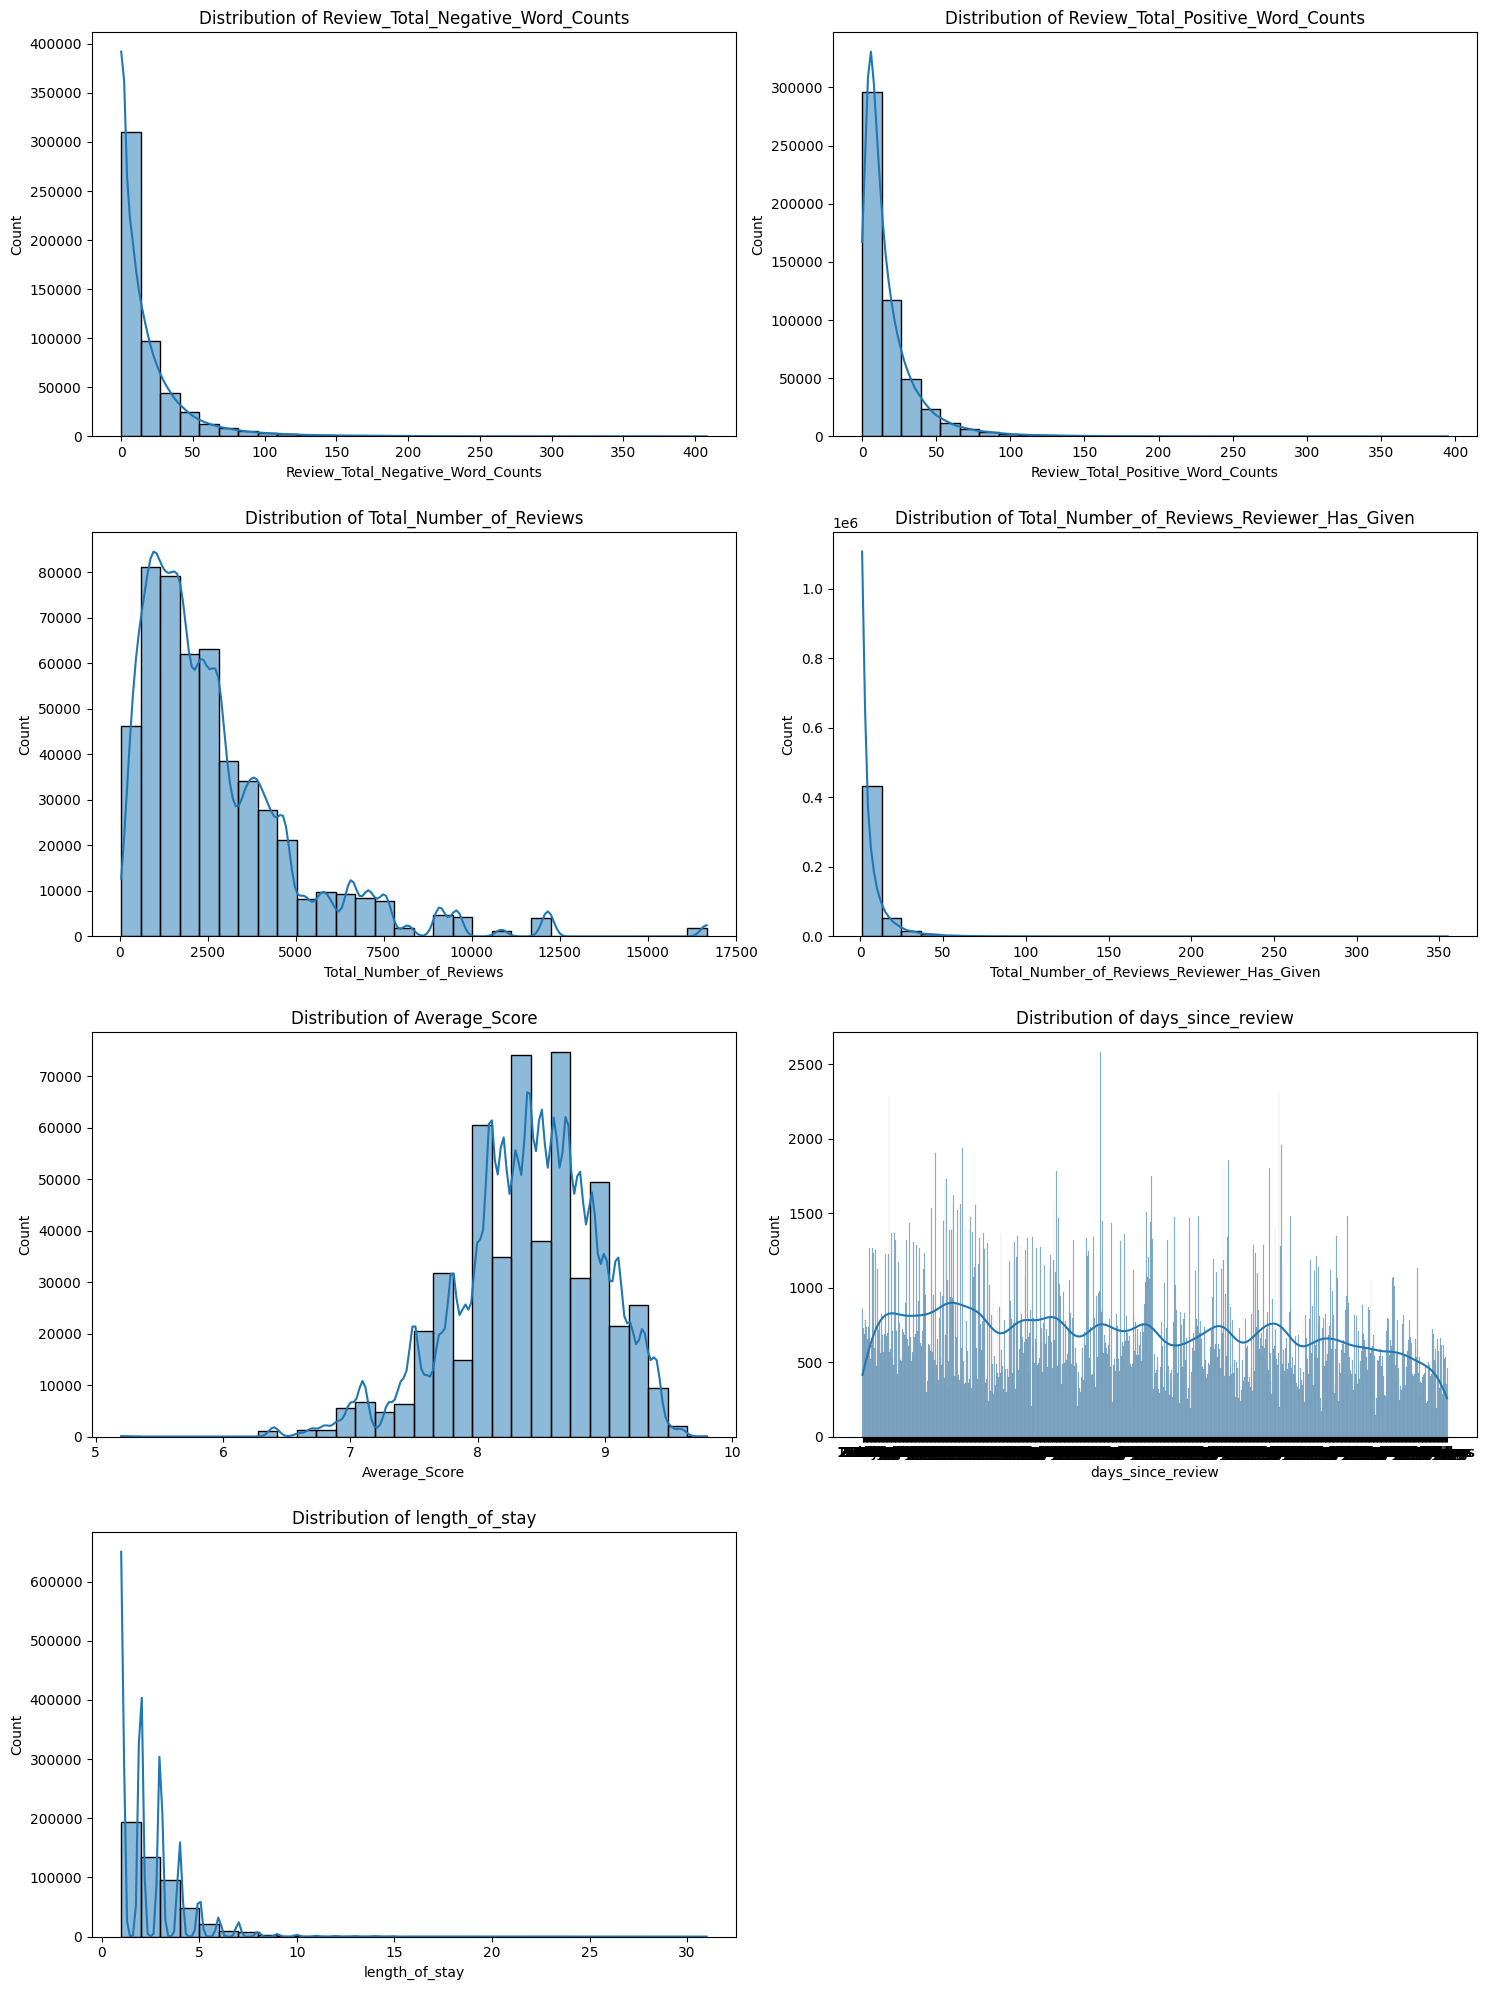


--- Bar Plots for Extracted Categorical Features ---


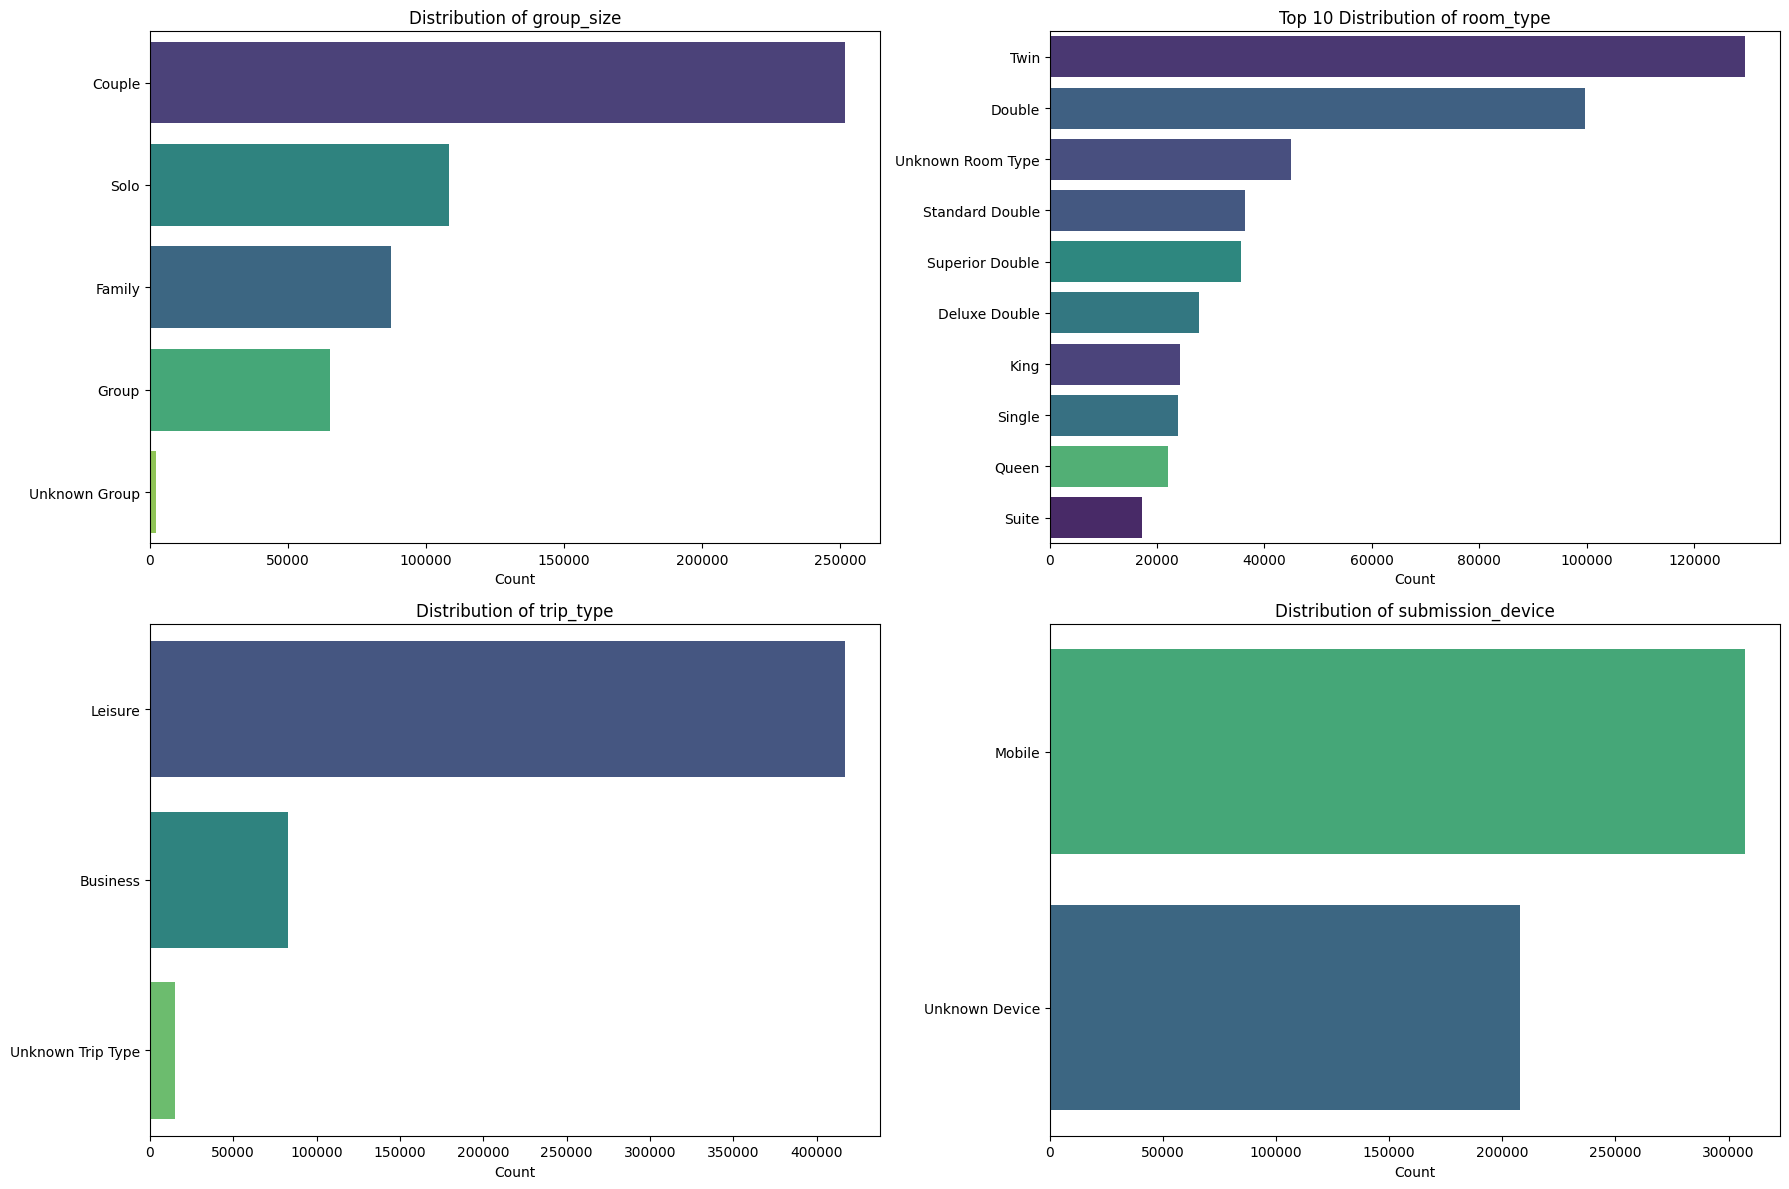


--- Top Reviewer Nationalities ---


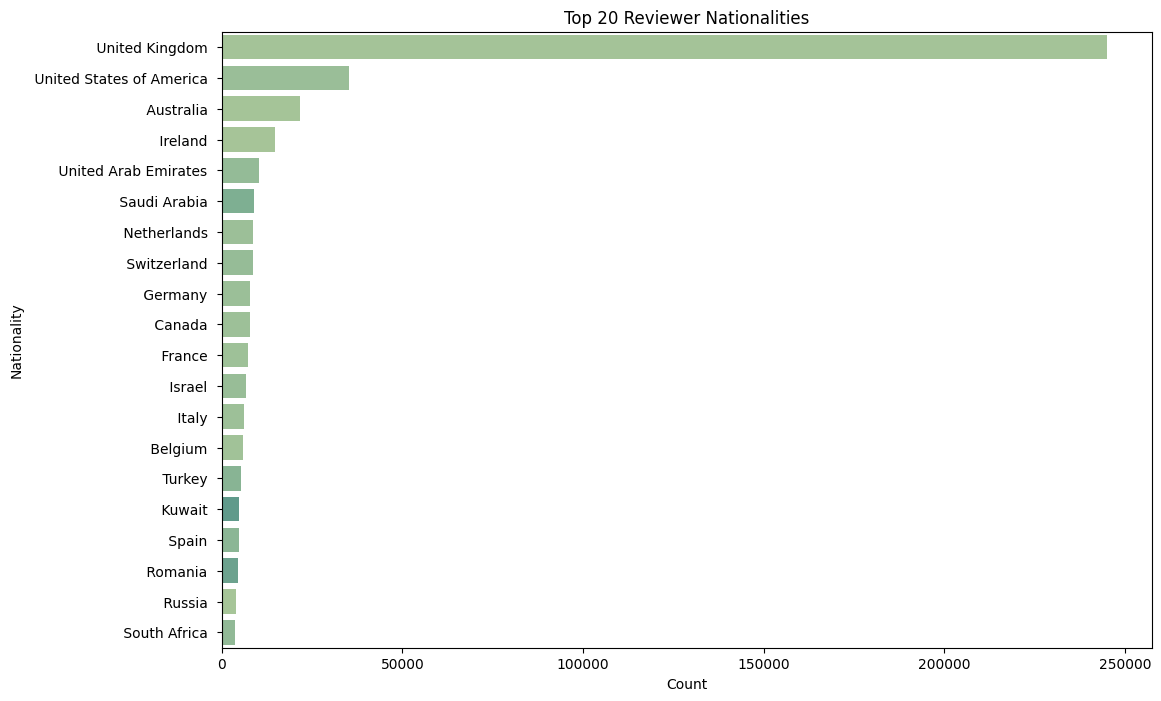

In [ ]:
# --- Numerical Features Histograms ---
numerical_cols = [
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews',
    'Total_Number_of_Reviews_Reviewer_Has_Given',
    'Average_Score',
    'days_since_review',
    'length_of_stay'
]

print("\n--- Histograms for Numerical Features ---")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten() # Flatten for easy iteration

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# --- Categorical Features Bar Plots ---
categorical_to_plot = [
    'group_size', 'room_type', 'trip_type', 'submission_device'
]

print("\n--- Bar Plots for Extracted Categorical Features ---")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_to_plot):
    # For room_type, take top N to avoid clutter
    if col == 'room_type':
        sns.countplot(y=df[col], order=df[col].value_counts().index[:10], ax=axes[i], palette='viridis', hue=df[col], legend=False)
        axes[i].set_title(f'Top 10 Distribution of {col}')
    else:
        sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis', hue=df[col], legend=False)
        axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n--- Top Reviewer Nationalities ---")
plt.figure(figsize=(12, 8))
sns.countplot(y='Reviewer_Nationality', data=df, order=df['Reviewer_Nationality'].value_counts().head(20).index, palette='crest', hue='Reviewer_Nationality', legend=False)
plt.title('Top 20 Reviewer Nationalities')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.show()


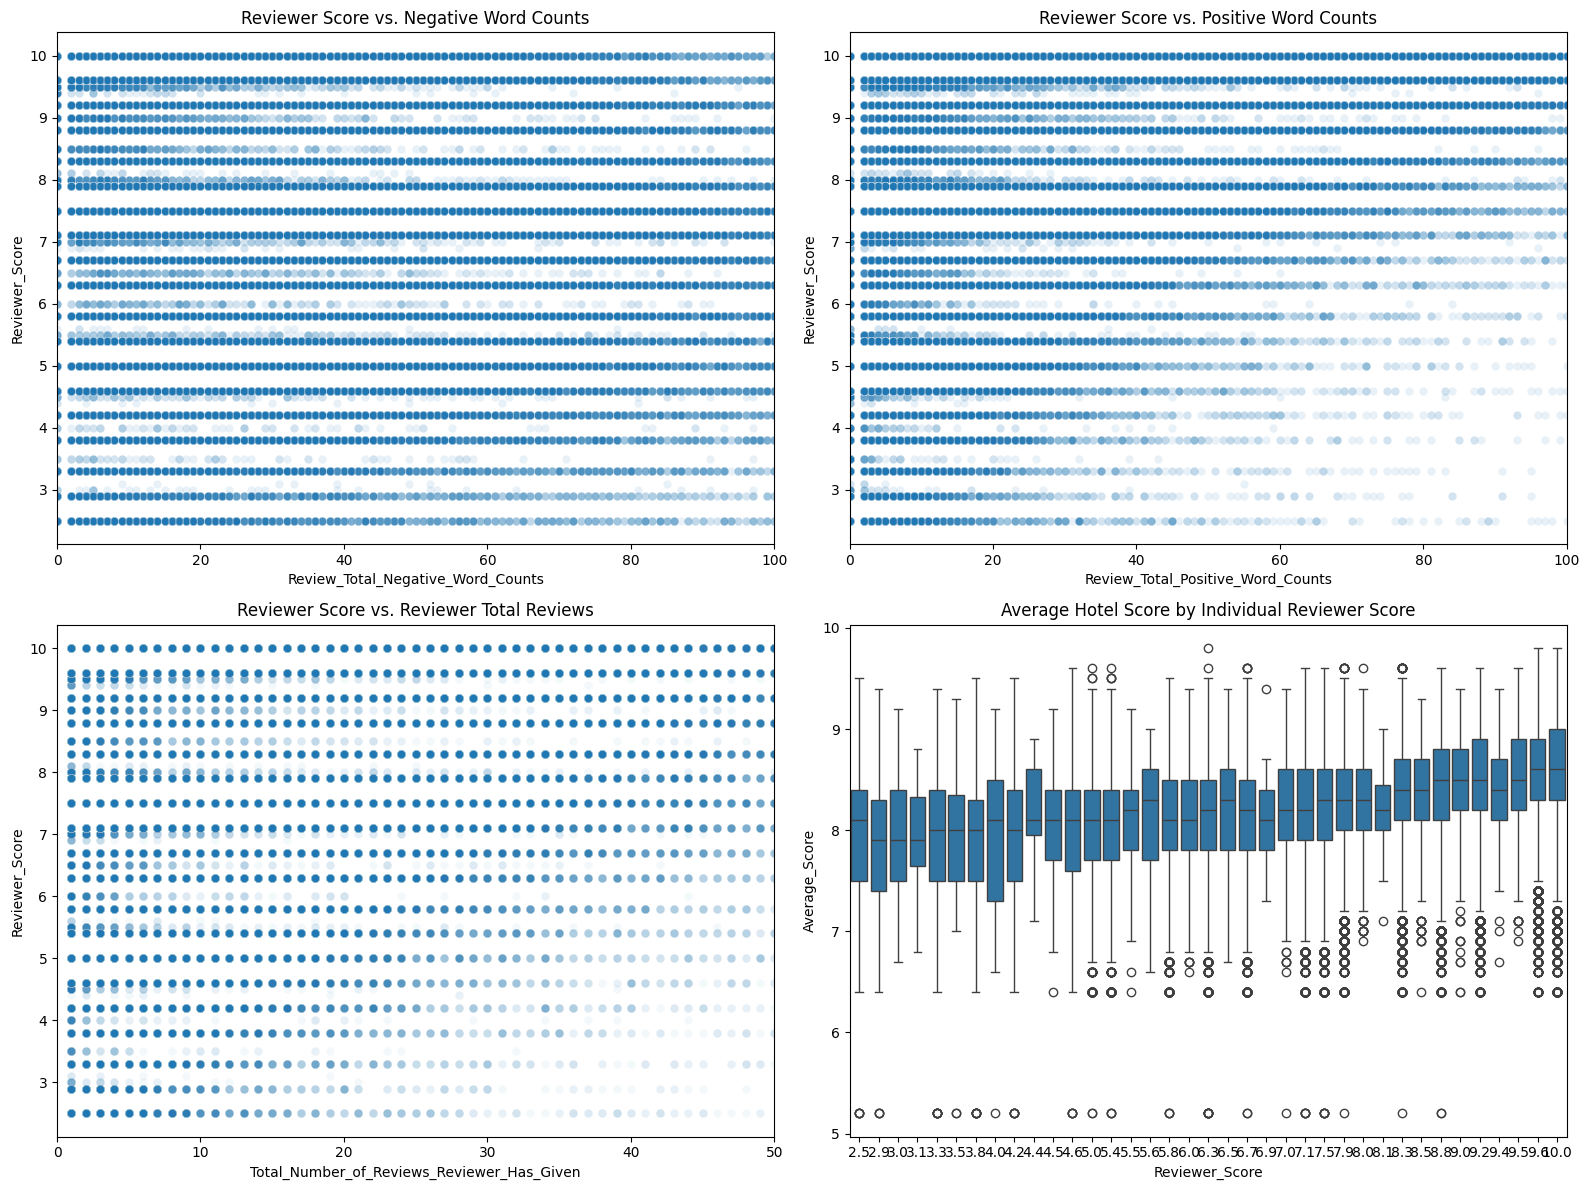

In [ ]:
# Scatter plots for continuous variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

sns.scatterplot(x='Review_Total_Negative_Word_Counts', y='Reviewer_Score', data=df, ax=axes[0], alpha=0.1)
axes[0].set_title('Reviewer Score vs. Negative Word Counts')
axes[0].set_xlim(0, 100)

sns.scatterplot(x='Review_Total_Positive_Word_Counts', y='Reviewer_Score', data=df, ax=axes[1], alpha=0.1)
axes[1].set_title('Reviewer Score vs. Positive Word Counts')
axes[1].set_xlim(0, 100)

sns.scatterplot(x='Total_Number_of_Reviews_Reviewer_Has_Given', y='Reviewer_Score', data=df, ax=axes[2], alpha=0.05)
axes[2].set_title('Reviewer Score vs. Reviewer Total Reviews')
axes[2].set_xlim(0, 50)

sns.boxplot(x='Reviewer_Score', y='Average_Score', data=df, ax=axes[3]) # Box plot, as Average_Score is hotel-level
axes[3].set_title('Average Hotel Score by Individual Reviewer Score')


plt.tight_layout()
plt.show()


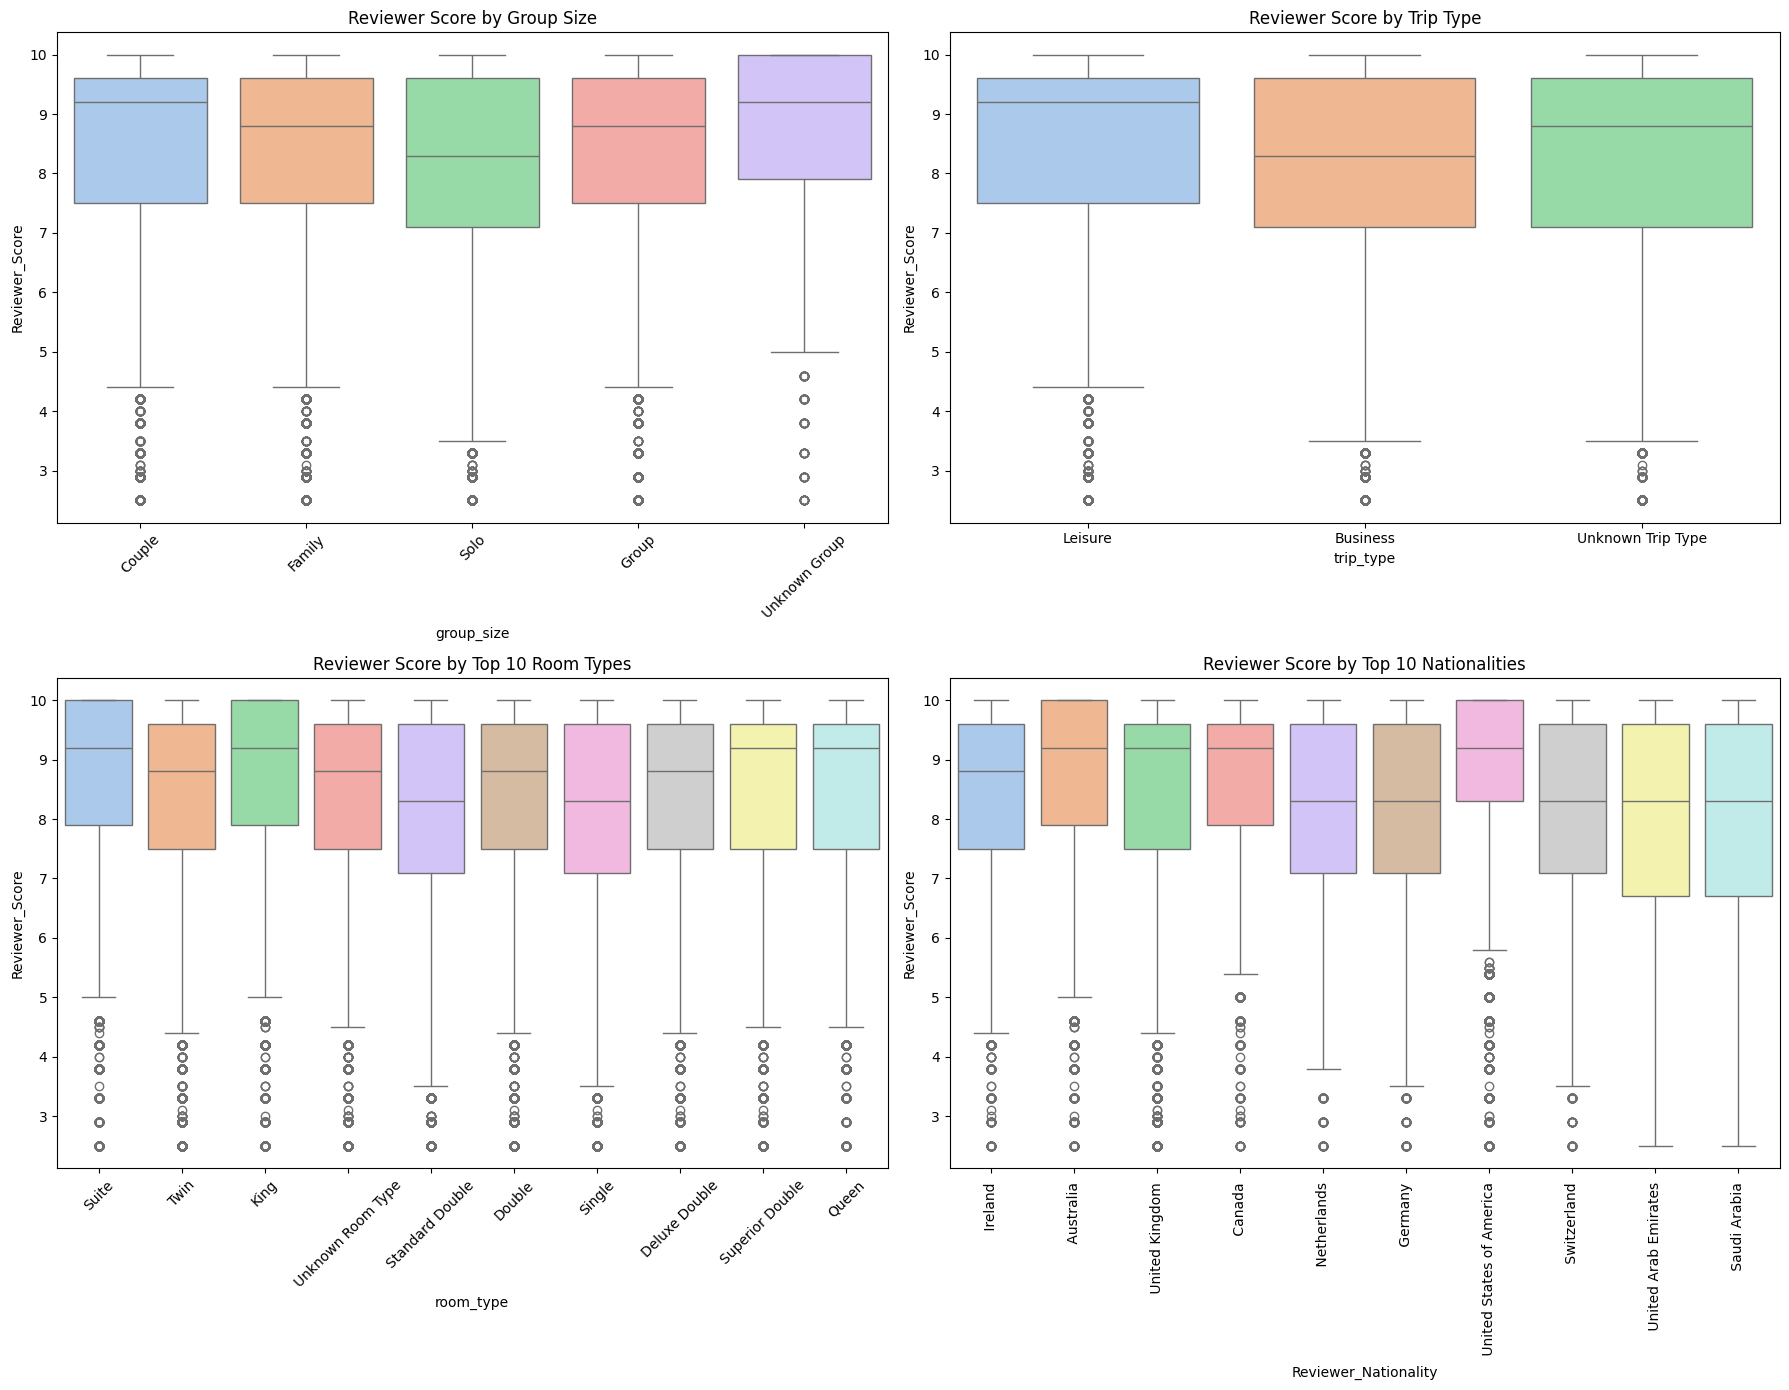

In [ ]:
# --- Reviewer_Score vs. Categorical Features (Box Plots) ---

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
axes = axes.flatten()

# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='group_size', y='Reviewer_Score', data=df, ax=axes[0], palette='pastel', hue='group_size', legend=False)
axes[0].set_title('Reviewer Score by Group Size')
axes[0].tick_params(axis='x', rotation=45)

# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='trip_type', y='Reviewer_Score', data=df, ax=axes[1], palette='pastel', hue='trip_type', legend=False)
axes[1].set_title('Reviewer Score by Trip Type')

top_room_types = df['room_type'].value_counts().head(10).index
# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='room_type', y='Reviewer_Score', data=df[df['room_type'].isin(top_room_types)], ax=axes[2], palette='pastel', hue='room_type', legend=False)
axes[2].set_title('Reviewer Score by Top 10 Room Types')
axes[2].tick_params(axis='x', rotation=45)

top_nationalities = df['Reviewer_Nationality'].value_counts().head(10).index
# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='Reviewer_Nationality', y='Reviewer_Score', data=df[df['Reviewer_Nationality'].isin(top_nationalities)], ax=axes[3], palette='pastel', hue='Reviewer_Nationality', legend=False)
axes[3].set_title('Reviewer Score by Top 10 Nationalities')
axes[3].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


--- Correlation Matrix of Numerical Features ---


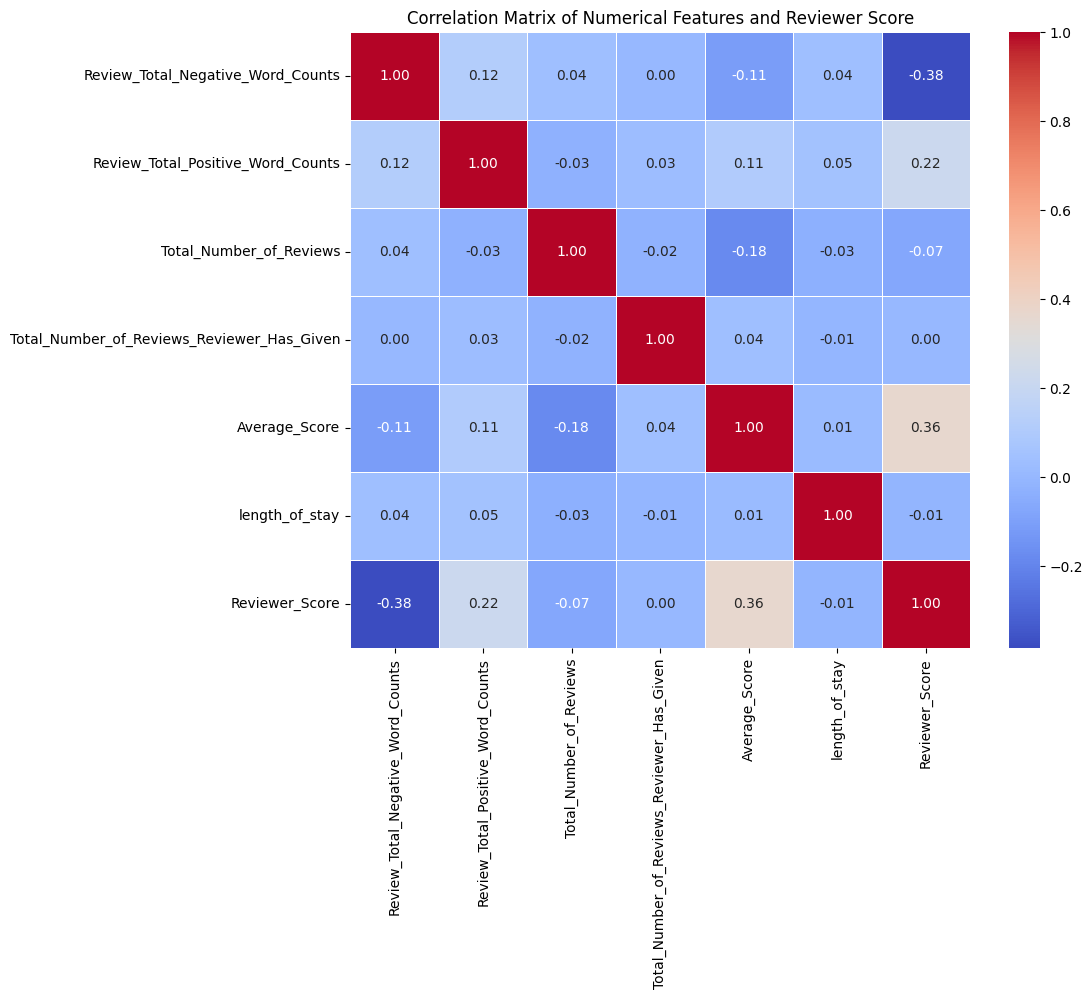

In [ ]:
# Correlation matrix for numerical features
print("\n--- Correlation Matrix of Numerical Features ---")
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols + ['Reviewer_Score']].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Reviewer Score')
plt.show()


--- Geographical Analysis ---

City and Country columns extracted.

City Distribution:
City
London       262298
Barcelona     60149
Paris         59413
Amsterdam     57211
Vienna        38937
Milan         37204
Name: count, dtype: int64

Country Distribution:
Country
United Kingdom    262298
Spain              60149
France             59413
Netherlands        57211
Austria            38937
Italy              37204
Name: count, dtype: int64


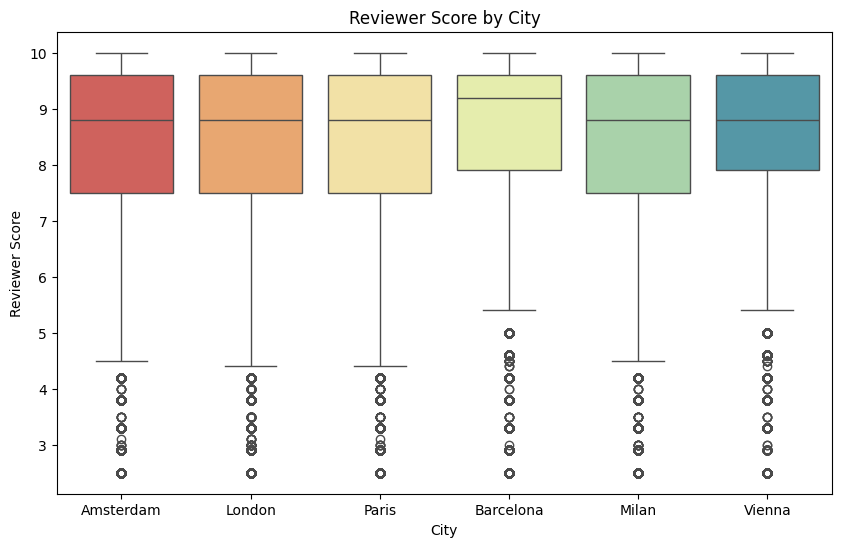

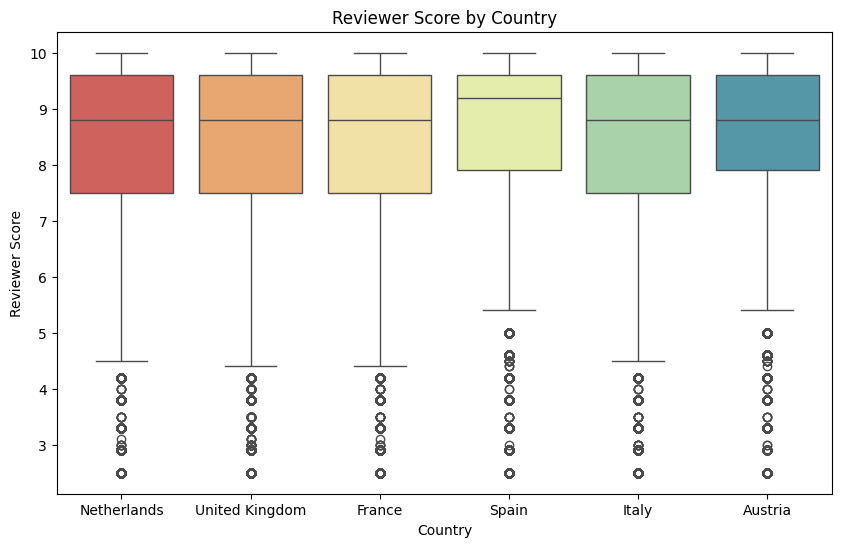


Top 10 Hotels by Average Reviewer Score:
                               Hotel_Name  Reviewer_Score
1202                           Ritz Paris        9.725000
598                     Hotel Casa Camper        9.718937
3                                      41        9.711650
472   H tel de La Tamise Esprit de France        9.688525
895                 Le Narcisse Blanc Spa        9.671930
481                 H10 Casa Mimosa 4 Sup        9.660345
628                   Hotel Eiffel Blomet        9.646667
771                      Hotel The Serras        9.623474
4      45 Park Lane Dorchester Collection        9.603571
1396                       The Soho Hotel        9.597452

Bottom 10 Hotels by Average Reviewer Score:
                                    Hotel_Name  Reviewer_Score
1401                         The Tophams Hotel        6.480000
600                            Hotel Cavendish        6.442065
1456                   Villa Lut ce Port Royal        6.385106
820               Ibis 

In [ ]:
# --- Geographical Analysis ---

print("\n--- Geographical Analysis ---")

def extract_city_country(address):
    # This heuristic assumes the predefined cities are in the address
    if 'London' in address: return 'London', 'United Kingdom'
    if 'Paris' in address: return 'Paris', 'France'
    if 'Milan' in address: return 'Milan', 'Italy'
    if 'Amsterdam' in address: return 'Amsterdam', 'Netherlands'
    if 'Barcelona' in address: return 'Barcelona', 'Spain'
    if 'Vienna' in address: return 'Vienna', 'Austria'
    return 'Unknown City', 'Unknown Country'

df['City'], df['Country'] = zip(*df['Hotel_Address'].apply(extract_city_country))

print("\nCity and Country columns extracted.")
print("\nCity Distribution:")
print(df['City'].value_counts())

print("\nCountry Distribution:")
print(df['Country'].value_counts())

plt.figure(figsize=(10, 6))
# ADDED hue='City' and legend=False
sns.boxplot(x='City', y='Reviewer_Score', data=df, palette='Spectral', hue='City', legend=False)
plt.title('Reviewer Score by City')
plt.xlabel('City')
plt.ylabel('Reviewer Score')
plt.show()

plt.figure(figsize=(10, 6))
# ADDED hue='Country' and legend=False
sns.boxplot(x='Country', y='Reviewer_Score', data=df, palette='Spectral', hue='Country', legend=False)
plt.title('Reviewer Score by Country')
plt.xlabel('Country')
plt.ylabel('Reviewer Score')
plt.show()

avg_score_per_hotel = df.groupby('Hotel_Name')['Reviewer_Score'].mean().reset_index()
avg_score_per_hotel = avg_score_per_hotel.sort_values(by='Reviewer_Score', ascending=False)
print("\nTop 10 Hotels by Average Reviewer Score:")
print(avg_score_per_hotel.head(10))
print("\nBottom 10 Hotels by Average Reviewer Score:")
print(avg_score_per_hotel.tail(10))


NLTK 'stopwords' corpus downloaded.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



'Review_Text' column created by combining Positive and Negative reviews.
                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                                      
2   Rooms are nice but for elderly a bit difficul...   
3   My room was dirty and I was afraid to walk ba...   
4   You When I booked with your company on line y...   

                                         Review_Text  
0   Only the park outside of the hotel was beauti...  
1   No real complaints the hotel was great great ...  
2   Location was good and staff were ok It is cut...  
3   Great location in nice surro

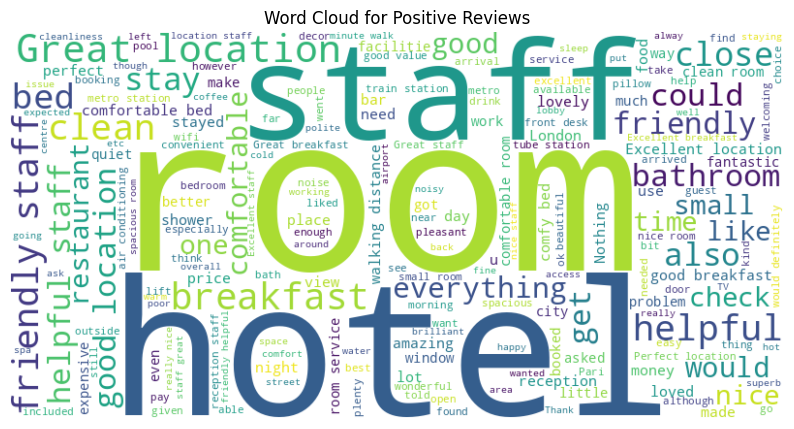


--- Word Cloud for Negative Reviews ---


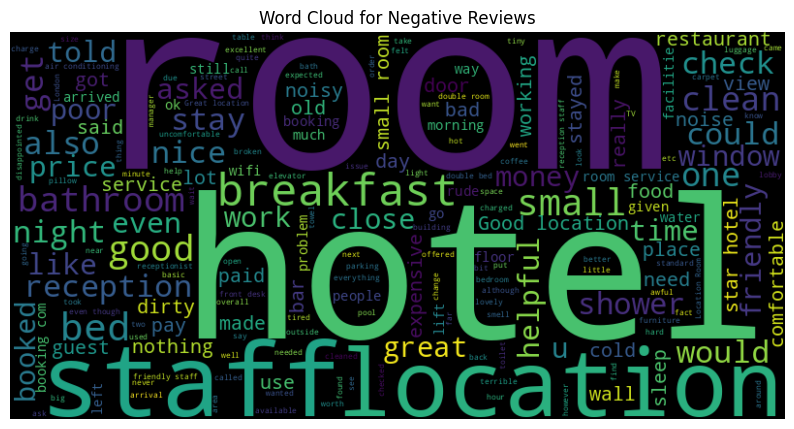


Average Review Length by Sentiment:
Sentiment
Negative    249.682911
Positive    173.041552
Name: review_length, dtype: float64


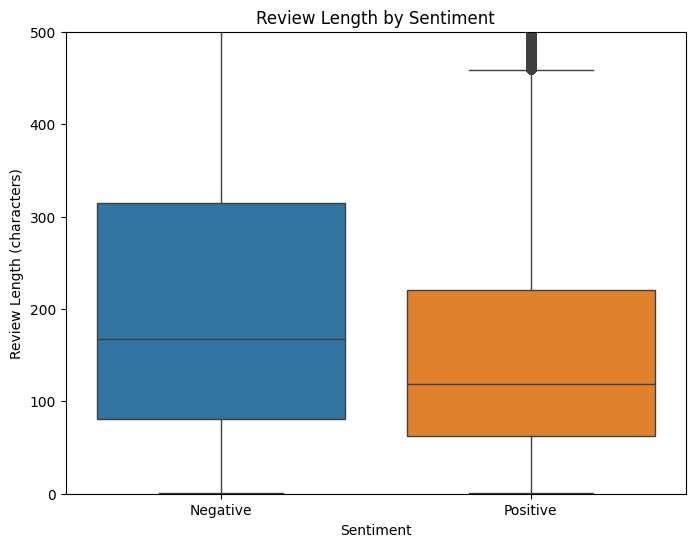

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK 'stopwords' corpus already downloaded.")
except LookupError: # Catch LookupError as raised by nltk.data.find()
    nltk.download('stopwords')
    print("NLTK 'stopwords' corpus downloaded.")

# Replace 'No Negative' and 'No Positive' with empty strings
df['Negative_Review'] = df['Negative_Review'].replace('No Negative', '')
df['Positive_Review'] = df['Positive_Review'].replace('No Positive', '')
df['Review_Text'] = df['Positive_Review'] + ' ' + df['Negative_Review']

print("\n'Review_Text' column created by combining Positive and Negative reviews.")
print(df[['Positive_Review', 'Negative_Review', 'Review_Text']].head())

# Create a 'sentiment' target variable
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')
print("\n'Sentiment' column created based on Reviewer_Score.")
print(df['Sentiment'].value_counts())

# Word Cloud for Positive Reviews
print("\n--- Word Cloud for Positive Reviews ---")
positive_reviews_text = " ".join(review for review in df[df['Sentiment'] == 'Positive']['Review_Text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white',
                               stopwords=set(nltk.corpus.stopwords.words('english'))).generate(positive_reviews_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud for Negative Reviews
print("\n--- Word Cloud for Negative Reviews ---")
negative_reviews_text = " ".join(review for review in df[df['Sentiment'] == 'Negative']['Review_Text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black',
                               stopwords=set(nltk.corpus.stopwords.words('english'))).generate(negative_reviews_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Review Length Analysis
df['review_length'] = df['Review_Text'].apply(len)
print("\nAverage Review Length by Sentiment:")
print(df.groupby('Sentiment')['review_length'].mean())

plt.figure(figsize=(8, 6))
# ADDED hue='Sentiment' and legend=False for consistency
sns.boxplot(x='Sentiment', y='review_length', data=df, hue='Sentiment', legend=False)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (characters)')
plt.ylim(0, 500)
plt.show()

#--- Deep dive further in the word analysis ---

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK 'stopwords' corpus already downloaded.")
except LookupError:
    nltk.download('stopwords')
    print("NLTK 'stopwords' corpus downloaded.")

NLTK 'stopwords' corpus already downloaded.


In [ ]:
# Remove the drop_duplicates line as duplicates were handled earlier
# df.drop_duplicates(inplace=True)

df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)

# Create 'Sentiment' target variable (from your previous steps)
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')

In [ ]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

print("\nApplying text preprocessing to 'Review_Text'...")
df['Review_Text_Clean'] = df['Review_Text'].apply(preprocess_text)
print("Text preprocessing complete.")




Applying text preprocessing to 'Review_Text'...
Text preprocessing complete.


In [ ]:
# --- TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams ---
print("\nStarting TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams...")
# Changed ngram_range to (1, 3) to include trigrams
tfidf_vectorizer_trigrams = TfidfVectorizer(max_features=15000, ngram_range=(1, 3)) # Increased max_features slightly due to more n-grams

# Fit and transform the cleaned review text
X_tfidf_trigrams = tfidf_vectorizer_trigrams.fit_transform(df['Review_Text_Clean'])

print(f"\nShape of TF-IDF matrix (with trigrams): {X_tfidf_trigrams.shape}")
print(f"Number of features (unique words/n-grams): {len(tfidf_vectorizer_trigrams.get_feature_names_out())}")
print("\nTF-IDF vectorization with trigrams complete.")



Starting TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams...

Shape of TF-IDF matrix (with trigrams): (515212, 15000)
Number of features (unique words/n-grams): 15000

TF-IDF vectorization with trigrams complete.


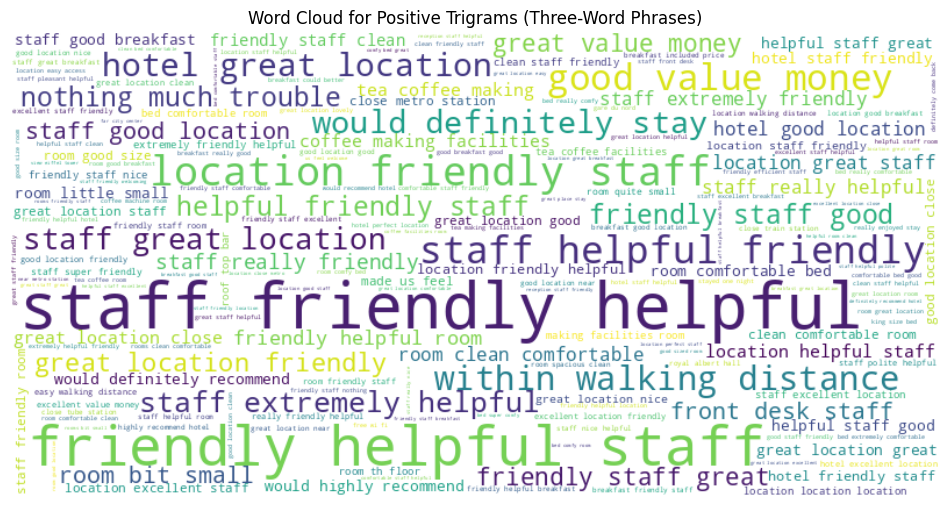

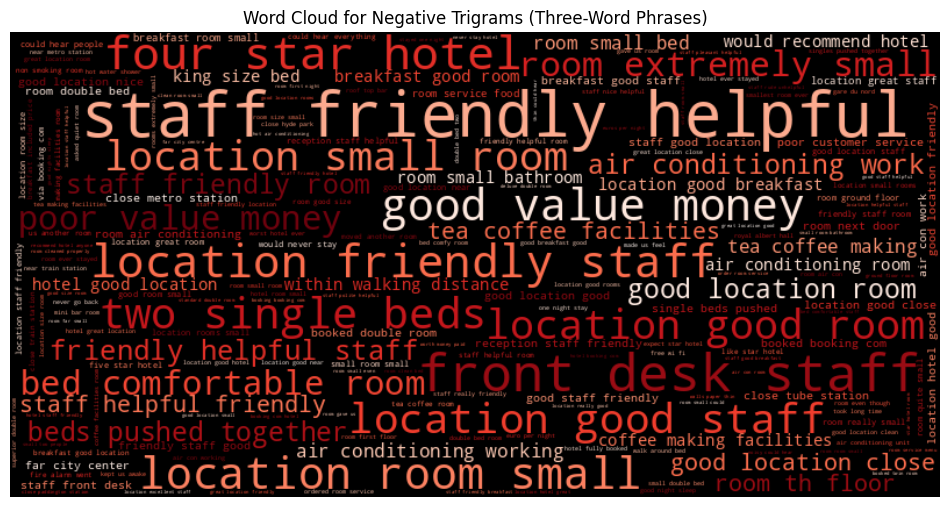


Word clouds for trigrams generated (if data was available).
Observe the difference in common phrases between positive and negative reviews.


In [ ]:
# Filter reviews by sentiment
positive_reviews_list = df[df['Sentiment'] == 'Positive']['Review_Text_Clean'].tolist()
negative_reviews_list = df[df['Sentiment'] == 'Negative']['Review_Text_Clean'].tolist()

# Handle cases where one of the lists might be empty after filtering (e.g., if a sentiment has no reviews)
if not positive_reviews_list:
    print("Warning: No positive reviews found after cleaning and filtering. Cannot generate positive trigram word cloud.")
    positive_trigram_dict = {} # Set to empty dict to avoid errors later
else:
    # Initialize CountVectorizer for trigrams only
    ngram_vectorizer_pos = CountVectorizer(ngram_range=(3, 3), max_features=2000)
    X_positive_trigrams = ngram_vectorizer_pos.fit_transform(positive_reviews_list)
    positive_trigram_counts = X_positive_trigrams.sum(axis=0)
    positive_trigram_freq = [(word, positive_trigram_counts[0, idx]) for word, idx in ngram_vectorizer_pos.vocabulary_.items()]
    positive_trigram_freq = sorted(positive_trigram_freq, key=lambda x: x[1], reverse=True)
    positive_trigram_dict = dict(positive_trigram_freq)


if not negative_reviews_list:
    print("Warning: No negative reviews found after cleaning and filtering. Cannot generate negative trigram word cloud.")
    negative_trigram_dict = {} # Set to empty dict
else:
    # Initialize CountVectorizer for trigrams only (use a new instance for negative reviews)
    ngram_vectorizer_neg = CountVectorizer(ngram_range=(3, 3), max_features=2000)
    X_negative_trigrams = ngram_vectorizer_neg.fit_transform(negative_reviews_list)
    negative_trigram_counts = X_negative_trigrams.sum(axis=0)
    negative_trigram_freq = [(word, negative_trigram_counts[0, idx]) for word, idx in ngram_vectorizer_neg.vocabulary_.items()]
    negative_trigram_freq = sorted(negative_trigram_freq, key=lambda x: x[1], reverse=True)
    negative_trigram_dict = dict(negative_trigram_freq)


# Generate Word Cloud for Positive Trigrams (only if dictionary is not empty)
if positive_trigram_dict:
    wordcloud_positive_trigrams = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_trigram_dict)
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud_positive_trigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Trigrams (Three-Word Phrases)')
    plt.show()
else:
    print("No positive trigram word cloud generated due to empty data.")


# Generate Word Cloud for Negative Trigrams (only if dictionary is not empty)
if negative_trigram_dict:
    wordcloud_negative_trigrams = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(negative_trigram_dict)
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud_negative_trigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Trigrams (Three-Word Phrases)')
    plt.show()
else:
    print("No negative trigram word cloud generated due to empty data.")


print("\nWord clouds for trigrams generated (if data was available).")
print("Observe the difference in common phrases between positive and negative reviews.")

In [ ]:
# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


In [ ]:
file_path = 'Hotel_Reviews.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("DataFrame loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure you unzipped the file correctly and it's in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")

df.drop_duplicates(inplace=True)
df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')

print(f"Total reviews after initial cleaning: {df.shape[0]}")


# --- USE THE FULL 500K+ DATASET FOR EMBEDDING GENERATION ---

df_full_data_for_bert = df.copy() # <<<--- Use a copy of the full DataFrame

# Delete the original 'df' to free up RAM early, as we'll now work with df_full_data_for_bert
if 'df' in locals():
    del df
    print("Original 'df' deleted from RAM as full data copy is created for BERT embeddings.")
gc.collect()


# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


# --- Load pre-trained BERT model and tokenizer ---
print("\nLoading BERT tokenizer and model...")
from transformers import AutoTokenizer, AutoModel # Added AutoModel import
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()
print("BERT tokenizer and model loaded.")


# --- Function to generate BERT embeddings in batches ---
def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings"):
        batch_texts = texts[i:min(i+batch_size, len(texts))]

        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

print(f"\nStarting BERT embedding generation on the FULL dataset of {df_full_data_for_bert.shape[0]} reviews.")

# Generate embeddings from the 'Review_Text' column of the FULL dataset
bert_embeddings_full_data = get_bert_embeddings(
    df_full_data_for_bert['Review_Text'].tolist(), # <<<--- Using df_full_data_for_bert
    tokenizer,
    model,
    device,
    batch_size=64,
    max_length=128
)

print(f"\nShape of generated BERT embeddings (full data): {bert_embeddings_full_data.shape}")
print("BERT embedding generation complete for full dataset.")


# --- ASSIGN X_BERT_FULL AND Y_BERT_FULL FOR TRAINING ---
X_bert_full = bert_embeddings_full_data
y_bert_full = df_full_data_for_bert['Sentiment'] # <<<--- Using sentiment from df_full_data_for_bert

print(f"\nShape of features (X_bert_full): {X_bert_full.shape}")
print(f"Shape of target (y_bert_full): {y_bert_full.shape}")


# --- SAVE THE BERT EMBEDDINGS AND PROCESSED FULL DATAFRAME ---
processed_df_path_full_data = 'hotel_reviews_processed_full_data.parquet'
bert_embeddings_path_full_data = 'bert_embeddings_full_data.npy'

print(f"\nSaving processed DataFrame (full data) to {processed_df_path_full_data}...")
df_full_data_for_bert.to_parquet(processed_df_path_full_data, index=False) # Saving the full data df
print("Processed DataFrame saved successfully!")

print(f"Saving BERT embeddings (full data) to {bert_embeddings_path_full_data}...")
np.save(bert_embeddings_path_full_data, X_bert_full) # Save the assigned X_bert_full
print("BERT embeddings saved successfully!")

print("\nRemember to download these files from the Colab 'Files' tab if you want to store them locally.")


DataFrame loaded successfully!
Total reviews after initial cleaning: 515212
Original 'df' deleted from RAM as full data copy is created for BERT embeddings.

Using device: cuda

Loading BERT tokenizer and model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT tokenizer and model loaded.

Starting BERT embedding generation on the FULL dataset of 515212 reviews.


Generating BERT Embeddings:   0%|          | 0/8051 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# --- Load Data Back for Supervised Sentiment Analysis (Logistic Regression) ---
print("\nLoading data back from saved files for Logistic Regression training...")
df_loaded_full_data = pd.read_parquet(processed_df_path_full_data)
print("DataFrame (full data) loaded back successfully!")

X_bert_full_loaded = np.load(bert_embeddings_path_full_data) # Load embeddings back into X_bert_full_loaded
print("BERT embeddings (full data) loaded back successfully!")

# Assign to variables for the next training step
X_bert_full = X_bert_full_loaded
y_bert_full = df_loaded_full_data['Sentiment']

# Clean up temporary loaded DataFrame if not strictly needed after y_bert_full assignment
if 'df_loaded_full_data' in locals():
    del df_loaded_full_data
    print("df_loaded_full_data deleted from RAM after y_bert_full assignment.")
gc.collect()
torch.cuda.empty_cache()

print(f"\nShape of features (X_bert_full - after reload): {X_bert_full.shape}")
print(f"Shape of target (y_bert_full - after reload): {y_bert_full.shape}")
print("Data reload complete for Logistic Regression.")


# --- Continue with Supervised Sentiment Analysis (Logistic Regression) ---
X_train_bert_full, X_test_bert_full, y_train_bert_full, y_test_bert_full = train_test_split(
    X_bert_full, y_bert_full, test_size=0.2, random_state=42, stratify=y_bert_full
)

print(f"\nShape of X_train_bert_full: {X_train_bert_full.shape}")
print(f"Shape of X_test_bert_full: {X_test_bert_full.shape}")

# Model Training (Logistic Regression)
print("\nTraining Logistic Regression model with BERT embeddings (FULL data)...")
log_reg_model_bert_full = LogisticRegression(solver='liblinear', max_iter=300, random_state=42)
log_reg_model_bert_full.fit(X_train_bert_full, y_train_bert_full)
print("Model training complete.")

# Model Prediction
print("\nMaking predictions on the test set with BERT embeddings (FULL data)...")
y_pred_bert_full = log_reg_model_bert_full.predict(X_test_bert_full)
print("Predictions made.")

# Model Evaluation
print("\n--- Model Evaluation (with BERT Embeddings - FULL Data) ---")
accuracy_bert_full = accuracy_score(y_test_bert_full, y_pred_bert_full)
print(f"Accuracy: {accuracy_bert_full:.4f}")

print("\nClassification Report (with BERT Embeddings - FULL Data):")
print(classification_report(y_test_bert_full, y_pred_bert_full))

cm_bert_full = confusion_matrix(y_test_bert_full, y_pred_bert_full, labels=log_reg_model_bert_full.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert_full, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive']) # Ensure correct labels
plt.title('Confusion Matrix (with BERT Embeddings - FULL Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nLogistic Regression model trained and evaluated using BERT embeddings on the FULL dataset.")

# --- Save the trained Logistic Regression model (FULL data) ---
model_save_path_full = "logistic_regression_model_bert_embeddings_full_data.joblib"
print(f"\nSaving the Logistic Regression model (full data) to: {model_save_path_full}...")
joblib.dump(log_reg_model_bert_full, model_save_path_full)
print("Logistic Regression model saved successfully!")

This is the TEST dataset we have

https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv

In [ ]:
# --- Define Paths to Saved Models and Data ---
# Path to your saved Logistic Regression model
model_save_path_full = "logistic_regression_model_bert_embeddings_full_data.joblib"

# Path to the BERT model and tokenizer for EMBEDDING GENERATION (these are pre-trained base models)
bert_base_model_name = 'bert-base-uncased'

# --- Define the direct link to your Google Sheet CSV (IMPORTANT: Publish to web as CSV!) ---
# Use the link that ends with /pub?output=csv from your Google Sheet.
new_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv"

# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device for inference: {device}")


# --- Load the Trained Logistic Regression Model ---
print(f"\nLoading the trained Logistic Regression model from '{model_save_path_full}'...")
try:
    log_reg_model_bert_full = joblib.load(model_save_path_full)
    print("Logistic Regression model loaded successfully!")
except FileNotFoundError:
    print(f"Error: Trained Logistic Regression model not found at '{model_save_path_full}'.")
    print("Please ensure you have successfully run the full training block and the model was saved.")
    exit() # Cannot proceed without the trained model
except Exception as e:
    print(f"An error occurred while loading the Logistic Regression model: {e}")
    exit()


# --- Load BERT model and tokenizer for EMBEDDING GENERATION for new data ---
# This is NOT your fine-tuned sentiment classifier, but the base BERT for feature extraction.
print(f"\nLoading BERT tokenizer and model '{bert_base_model_name}' for new data embedding generation...")
try:
    tokenizer = AutoTokenizer.from_pretrained(bert_base_model_name)
    model = AutoModel.from_pretrained(bert_base_model_name)
    model.to(device)
    model.eval()
    print("BERT tokenizer and model loaded/ready for embedding generation.")
except Exception as e:
    print(f"Error loading BERT model/tokenizer for embedding generation: {e}")
    print("Cannot proceed with new data inference without BERT embedding capabilities.")
    exit()


# --- Function to generate BERT embeddings in batches ---
def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings for New Data"):
        batch_texts = texts[i:min(i+batch_size, len(texts))]
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

In [ ]:
# --- Define Paths to Saved Models and Data ---
# Path to your saved Logistic Regression model
model_save_path_full = "logistic_regression_model_bert_embeddings_full_data.joblib"

# Path to the BERT model and tokenizer for EMBEDDING GENERATION (these are pre-trained base models)
bert_base_model_name = 'bert-base-uncased'

# --- Define the direct link to your Google Sheet CSV (IMPORTANT: Publish to web as CSV!) ---
new_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv"

# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device for inference: {device}")


# --- Load the Trained Logistic Regression Model ---
print(f"\nLoading the trained Logistic Regression model from '{model_save_path_full}'...")
try:
    log_reg_model_bert_full = joblib.load(model_save_path_full)
    print("Logistic Regression model loaded successfully!")
except FileNotFoundError:
    print(f"Error: Trained Logistic Regression model not found at '{model_save_path_full}'.")
    print("Please ensure you have successfully run the full training block and the model was saved.")
    exit() # Cannot proceed without the trained model
except Exception as e:
    print(f"An error occurred while loading the Logistic Regression model: {e}")
    exit()


# --- Load BERT model and tokenizer for EMBEDDING GENERATION for new data ---
print(f"\nLoading BERT tokenizer and model '{bert_base_model_name}' for new data embedding generation...")
try:
    tokenizer = AutoTokenizer.from_pretrained(bert_base_model_name)
    model = AutoModel.from_pretrained(bert_base_model_name)
    model.to(device)
    model.eval()
    print("BERT tokenizer and model loaded/ready for embedding generation.")
except Exception as e:
    print(f"Error loading BERT model/tokenizer for embedding generation: {e}")
    print("Cannot proceed with new data inference without BERT embedding capabilities.")
    exit()


# --- Function to generate BERT embeddings in batches ---
def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings for New Data"):
        batch_texts = texts[i:min(i+batch_size, len(texts))]
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())
    return np.vstack(all_embeddings)


# --- Load and Prepare New Data from Google Sheet ---
print(f"\nLoading new data from '{new_data_url}'...")
data_ready_for_inference = False
try:
    new_reviews_df = pd.read_csv(new_data_url)
    print("New data loaded successfully (assuming header is in first row)!")
    print("\nFirst 5 rows of the new data:")
    print(new_reviews_df.head())
    print(f"\nAvailable columns: {new_reviews_df.columns.tolist()}")

    # --- PREPARING TEXT OF NEW REVIEWS ---
    if 'Review_Text' in new_reviews_df.columns:
        new_reviews_df['review_text_for_bert'] = new_reviews_df['Review_Text'].astype(str)
        print("\n'Review_Text' column found and used for inference text.")
        data_ready_for_inference = True
    elif 'Positive_Review' in new_reviews_df.columns and 'Negative_Review' in new_reviews_df.columns:
        new_reviews_df['review_text_for_bert'] = new_reviews_df['Positive_Review'].astype(str).replace('No Positive', '') + ' ' + \
                                                 new_reviews_df['Negative_Review'].astype(str).replace('No Negative', '')
        new_reviews_df['review_text_for_bert'] = new_reviews_df['review_text_for_bert'].str.strip().str.replace(r'\s+', ' ', regex=True)
        print("\n'review_text_for_bert' column created from Positive and Negative reviews (fallback).")
        data_ready_for_inference = True
    else:
        print("\nError: No suitable review text column ('Review_Text' or 'Positive_Review'/'Negative_Review') found in new data.")
        print("Please ensure your new data has a column containing the review text matching one of these names.")
        data_ready_for_inference = False

    if data_ready_for_inference:
        original_rows_count = len(new_reviews_df)
        new_reviews_df.dropna(subset=['review_text_for_bert'], inplace=True)
        new_reviews_df = new_reviews_df[new_reviews_df['review_text_for_bert'].str.strip() != '']
        if len(new_reviews_df) < original_rows_count:
            print(f"Removed {original_rows_count - len(new_reviews_df)} rows due to empty review text after processing.")

        if new_reviews_df.empty:
            print("No valid review text found in the new data after preprocessing. Cannot perform inference.")
            data_ready_for_inference = False

except Exception as e:
    print(f"Error loading or preparing new data: {e}")
    print("Ensure the published link is correct and ends with '/pub?output=csv', or the local file exists.")
    data_ready_for_inference = False


if data_ready_for_inference:
    # --- Generate BERT Embeddings for New Data ---
    print("\nGenerating BERT embeddings for new data...")
    new_data_bert_embeddings = get_bert_embeddings(
        new_reviews_df['review_text_for_bert'].tolist(),
        tokenizer, # Use the BERT tokenizer for embedding generation
        model,     # Use the BERT model for embedding generation
        device,
        batch_size=64, # Adjust batch size based on GPU memory
        max_length=128
    )
    print(f"\nShape of new data BERT embeddings: {new_data_bert_embeddings.shape}")
    print("BERT embeddings for new data generated.")


    # --- Perform Prediction using the Trained Logistic Regression Model ---
    print("\nMaking predictions on new data using Logistic Regression model...")
    predictions_string_labels = log_reg_model_bert_full.predict(new_data_bert_embeddings)

    new_reviews_df['Predicted_Sentiment'] = predictions_string_labels

    print("\nInference complete. Predictions added to the new DataFrame.")
    print("\nNew Data with Predictions (first 10 rows):")
    print(new_reviews_df[['review_text_for_bert', 'Predicted_Sentiment']].head(10))


    # --- INTEGRATED SAVE OF PREDICTIONS HERE ---
    predictions_output_csv_path = "new_reviews_with_predicted_sentiments.csv"
    predictions_output_parquet_path = "new_reviews_with_predicted_sentiments.parquet"

    print(f"\nSaving new reviews with predictions to CSV: {predictions_output_csv_path}...")
    new_reviews_df.to_csv(predictions_output_csv_path, index=False)
    print("Saved to CSV successfully!")

    print(f"Saving new reviews with predictions to Parquet: {predictions_output_parquet_path}...")
    new_reviews_df.to_parquet(predictions_output_parquet_path, index=False)
    print("Saved to Parquet successfully!")

    print("\nThese files are now available in your Colab 'Files' tab. Download them to inspect all predictions.")
    # --- END INTEGRATED SAVE ---


    # --- OPTIONAL: EVALUATE IF GROUND TRUTH LABELS ARE AVAILABLE ---
    if 'Reviewer_Score' in new_reviews_df.columns:
        print("\n--- Evaluating Model Performance on New Data (Ground Truth Available) ---")
        label_map = {'Negative': 0, 'Positive': 1}
        actual_scores = new_reviews_df['Reviewer_Score']
        actual_labels = actual_scores.apply(lambda score: 'Positive' if score >= 7 else 'Negative')
        actual_numeric_labels = actual_labels.map(label_map).tolist()

        accuracy = accuracy_score(actual_numeric_labels, [label_map[p] for p in predictions_string_labels])
        print(f"Accuracy on new data: {accuracy:.4f}")

        print("\nClassification Report on New Data:")
        print(classification_report(actual_numeric_labels, [label_map[p] for p in predictions_string_labels], target_names=['Negative', 'Positive']))

        cm = confusion_matrix(actual_numeric_labels, [label_map[p] for p in predictions_string_labels], labels=[0, 1])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title('Confusion Matrix on New Data')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    else:
        print("\nNo 'Reviewer_Score' (or equivalent) column found in the new data for evaluation.")
        print("Cannot calculate full evaluation metrics, but predictions have been generated.")

else:
    print("\nSkipping inference as new data could not be loaded or prepared successfully.")

In [ ]:
# Ensure new_reviews_df is still in memory from the last successful run
# (It should be, unless you restarted the kernel after the last output)
if 'new_reviews_df' in locals():
    predictions_output_csv_path = "new_reviews_with_predicted_sentiments.csv"
    predictions_output_parquet_path = "new_reviews_with_predicted_sentiments.parquet"

    print(f"\nSaving new reviews with predictions to CSV: {predictions_output_csv_path}...")
    new_reviews_df.to_csv(predictions_output_csv_path, index=False)
    print("Saved to CSV successfully!")

    print(f"Saving new reviews with predictions to Parquet: {predictions_output_parquet_path}...")
    new_reviews_df.to_parquet(predictions_output_parquet_path, index=False)
    print("Saved to Parquet successfully!")

    print("\nThese files are now available in your Colab 'Files' tab. Download them to inspect all 60,000 predictions.")
else:
    print("new_reviews_df not found in memory. Please ensure the inference cell was run recently.")

In [ ]:
# After the inference cell completes:
print("\nDistribution of Predicted Sentiments:")
print(new_reviews_df['Predicted_Sentiment'].value_counts())

In [ ]:
# Assuming the inference cell just completed and new_reviews_df is in memory
import pandas as pd # Ensure pandas is imported if running this in a new cell

predictions_output_csv_path = "new_reviews_with_predicted_sentiments.csv"
predictions_output_parquet_path = "new_reviews_with_predicted_sentiments.parquet"

print(f"\nSaving new reviews with predictions to CSV: {predictions_output_csv_path}...")
new_reviews_df.to_csv(predictions_output_csv_path, index=False)
print("Saved to CSV successfully!")

print(f"Saving new reviews with predictions to Parquet: {predictions_output_parquet_path}...")
new_reviews_df.to_parquet(predictions_output_parquet_path, index=False)
print("Saved to Parquet successfully!")

print("\nThese files are now available in your Colab 'Files' tab.")
print("Remember to download them if you want to store them locally.")

In [ ]:
# Assuming log_reg_model_bert_full is in memory from your previous training
model_save_path = "logistic_regression_model_bert_embeddings.joblib"

print(f"\nSaving the Logistic Regression model to: {model_save_path}...")
joblib.dump(log_reg_model_bert_full, model_save_path)
print("Logistic Regression model saved successfully!")

# ---In order to not run everything again we can just run this last cell only  ---

In [ ]:
# Load the predictions DataFrame
loaded_predictions_df = pd.read_csv("new_reviews_with_predicted_sentiments.csv")
# Or: loaded_predictions_df = pd.read_parquet("new_reviews_with_predicted_sentiments.parquet")
print("Predictions DataFrame loaded.")

# Load the trained Logistic Regression model
loaded_log_reg_model = joblib.load("logistic_regression_model_bert_embeddings.joblib")
print("Logistic Regression model loaded.")

# If you also need the BERT embeddings for the training data (for evaluation, etc.)
# X_bert_full_reloaded = np.load("bert_embeddings_subset_data.npy") # Or _full_data.npy if you used full
# print("Training BERT embeddings loaded.")
# df_subset_reloaded = pd.read_parquet("hotel_reviews_processed_subset_data.parquet") # Or _full_data.parquet
# print("Training DataFrame loaded.")

In [ ]:
# --- Configuration ---
FILE_PATH = 'Hotel_Reviews.csv' # Make sure this file is uploaded to your Colab environment or accessible
MODEL_CHECKPOINT = "distilbert-base-uncased"
MAX_LENGTH = 128 # Max sequence length for tokenizer
TRAIN_BATCH_SIZE = 32 # Adjust based on your GPU VRAM. Lower if you get OOM errors.
EVAL_BATCH_SIZE = 32
NUM_TRAIN_EPOCHS = 3 # Typically 2-4 epochs are sufficient for fine-tuning BERT-like models
LEARNING_RATE = 2e-5 # Standard learning rate for fine-tuning transformers
OUTPUT_DIR = "./results_finetuned_distilbert" # Directory to save model checkpoints and logs
MODEL_SAVE_PATH = "./fine_tuned_distilbert_hotel_reviews" # Final model save path

# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device for fine-tuning: {device}")

# --- 1. Load the Full Dataset ---
print(f"Loading dataset from '{FILE_PATH}'...")
try:
    df = pd.read_csv(FILE_PATH, low_memory=False)
    print(f"DataFrame loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found.")
    print("Please ensure you have downloaded and unzipped '515k-hotel-reviews-data-in-europe.zip' and 'Hotel_Reviews.csv' is in the current working directory.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")
    exit()

# --- 2. Preprocess the Data ---
print("\nPreprocessing data...")
df.drop_duplicates(inplace=True)
df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
# Drop original review columns to save memory if not needed later
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean', 'Positive_Review', 'Negative_Review'], inplace=True)

# Create sentiment labels (0 for negative, 1 for positive)
# Hugging Face models expect integer labels starting from 0 for classification tasks
df['Sentiment_Label'] = df['Reviewer_Score'].apply(lambda score: 1 if score >= 7 else 0) # 1:Positive, 0:Negative

print(f"Total reviews after cleaning and sentiment labeling: {df.shape[0]}")
print(f"Sentiment distribution:\n{df['Sentiment_Label'].value_counts(normalize=True)}")

# Split into training, validation, and test sets
# It's good practice to have a separate validation set for hyperparameter tuning and early stopping
# and a test set for final, unbiased evaluation.
# Using 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment_Label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Sentiment_Label']) # 0.5 of 0.2 = 0.1 total

print(f"\nTrain set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Clean up original dataframe to free memory
del df, temp_df
gc.collect()
torch.cuda.empty_cache()

# --- 3. Tokenization ---
print(f"\nLoading tokenizer '{MODEL_CHECKPOINT}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    # Ensure all inputs are strings and handle potential NaN values by converting to empty string
    return tokenizer(
        [str(text) if pd.notna(text) else "" for text in examples["Review_Text"]],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

print("\nTokenizing datasets...")
# Convert pandas DataFrames to Hugging Face Dataset objects
# This is crucial for using the map function efficiently and the Trainer API
# Keep only necessary columns for the dataset and rename 'Sentiment_Label' to 'labels'
raw_train_dataset = Dataset.from_pandas(train_df)
raw_val_dataset = Dataset.from_pandas(val_df)
raw_test_dataset = Dataset.from_pandas(test_df)

# Use `keep_in_memory=False` for very large datasets if memory is an issue
tokenized_train_dataset = raw_train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=[col for col in train_df.columns if col not in ['Review_Text', 'Sentiment_Label']],
    desc="Tokenizing training data"
)
tokenized_val_dataset = raw_val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=[col for col in val_df.columns if col not in ['Review_Text', 'Sentiment_Label']],
    desc="Tokenizing validation data"
)
tokenized_test_dataset = raw_test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=[col for col in test_df.columns if col not in ['Review_Text', 'Sentiment_Label']],
    desc="Tokenizing test data"
)

# Rename 'Sentiment_Label' to 'labels' for the Trainer API
tokenized_train_dataset = tokenized_train_dataset.rename_column("Sentiment_Label", "labels")
tokenized_val_dataset = tokenized_val_dataset.rename_column("Sentiment_Label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("Sentiment_Label", "labels")

# Set the format for PyTorch
tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("\nTokenization complete. Example entry:")
print(tokenized_train_dataset[0])
print(f"Shape of tokenized_train_dataset: {len(tokenized_train_dataset)}")
print(f"Shape of tokenized_val_dataset: {len(tokenized_val_dataset)}")
print(f"Shape of tokenized_test_dataset: {len(tokenized_test_dataset)}")

# Clean up pandas dataframes to free memory
del train_df, val_df, test_df
gc.collect()
torch.cuda.empty_cache()


# --- 5. Load the Pre-trained Model ---
print(f"\nLoading '{MODEL_CHECKPOINT}' model for sequence classification (num_labels=2)...")
# AutoModelForSequenceClassification loads the base model with a classification head
# `num_labels=2` because we have two classes: Negative (0) and Positive (1)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)
model.to(device) # Move model to GPU if available
print("Model loaded and moved to device.")


# --- 6. Define Training Arguments ---
print("\nSetting up TrainingArguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,               # output directory for model checkpoints and logs
    num_train_epochs=NUM_TRAIN_EPOCHS,   # total number of training epochs
    per_device_train_batch_size=TRAIN_BATCH_SIZE, # batch size per GPU/CPU for training
    per_device_eval_batch_size=EVAL_BATCH_SIZE,   # batch size per GPU/CPU for evaluation
    warmup_steps=500,                    # number of warmup steps for learning rate scheduler
    learning_rate=LEARNING_RATE,         # initial learning rate for AdamW optimizer
    weight_decay=0.01,                   # strength of weight decay regularization
    logging_dir="./logs",                # directory for storing logs
    # Corrected arguments:
    eval_strategy="epoch",               # Evaluate at the end of each epoch
    save_strategy="epoch",               # Save checkpoint at the end of each epoch
    logging_steps=500,                   # Log training metrics every 500 steps
    load_best_model_at_end=True,         # load the best model (according to eval_loss) at the end of training
    metric_for_best_model="eval_f1_macro",     # metric to use to compare models (aim for higher F1)<------------------------------------------not what we need for binary #######################
    greater_is_better=True,              # Higher F1 is better
    report_to="none",                    # Disable W&B if not needed, or set to "tensorboard" etc.
    fp16=torch.cuda.is_available(),      # Enable mixed precision training if GPU is available
    gradient_accumulation_steps=1,       # Number of updates steps to accumulate before performing a backward/update pass. Increase if batch_size is small to simulate larger effective batch.
)
print("TrainingArguments configured.")


# --- 7. Define Metrics ---
# This function will be called by the Trainer at each evaluation step
def compute_metrics(eval_pred):
    logits, labels = eval_pred # logits are the raw outputs from the model, labels are the true labels
    predictions = np.argmax(logits, axis=-1) # Convert logits to class predictions (0 or 1)

    # Calculate overall accuracy
    acc = accuracy_score(labels, predictions)

    # Calculate precision, recall, f1 for both classes (macro average)
    # Use 'binary' average for two classes and specify `pos_label` if you want it focused on positive class
    # For a balanced view, 'macro' or 'weighted' average is often preferred
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0) # Added zero_division

    # Get detailed classification report for specific class metrics
    class_report_dict = classification_report(labels, predictions, target_names=['Negative', 'Positive'], output_dict=True, zero_division=0)

    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_positive': class_report_dict['Positive']['f1-score'],
        'precision_positive': class_report_dict['Positive']['precision'],
        'recall_positive': class_report_dict['Positive']['recall'],
        'f1_negative': class_report_dict['Negative']['f1-score'],
        'precision_negative': class_report_dict['Negative']['precision'],
        'recall_negative': class_report_dict['Negative']['recall'],
    }


# --- 8. Initialize and Run the Trainer ---
print("\nInitializing Trainer...")
# FutureWarning about `tokenizer` is okay, it just means they might change the arg name later.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset, # Use validation set for evaluation during training
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, # Pass tokenizer to Trainer for proper padding/collation
)

print("Starting model fine-tuning. This may take a while depending on your GPU and dataset size...")
trainer.train()
print("Fine-tuning complete.")

# --- Evaluate on the Unseen Test Set ---
print("\n--- Evaluating on the unseen Test Set ---")
# This will run `compute_metrics` on the test set
test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Set Evaluation Results: {test_results}")

# Generate predictions for the confusion matrix and full report
predictions_output = trainer.predict(tokenized_test_dataset)
y_pred_logits = predictions_output.predictions # Raw logits from the model
y_pred_labels = np.argmax(y_pred_logits, axis=-1) # Predicted class (0 or 1)
y_true_labels = predictions_output.label_ids # True labels (0 or 1)

print("\n--- Full Classification Report on Test Set (Fine-tuned DistilBERT) ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set (Fine-tuned DistilBERT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 9. Save the Fine-tuned Model ---
print(f"\nSaving fine-tuned model and tokenizer to: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH) # Saves model weights and configuration
tokenizer.save_pretrained(MODEL_SAVE_PATH) # Saves tokenizer files
print("Fine-tuned model and tokenizer saved successfully!")

print(f"\nTo load this model later for inference, use:")
print(f"  from transformers import AutoTokenizer, AutoModelForSequenceClassification")
print(f"  tokenizer_loaded = AutoTokenizer.from_pretrained('{MODEL_SAVE_PATH}')")
print(f"  model_loaded = AutoModelForSequenceClassification.from_pretrained('{MODEL_SAVE_PATH}')")
print(f"  model_loaded.to('cuda' if torch.cuda.is_available() else 'cpu')")



In [ ]:
# --- Re-define Configuration (if running in a separate cell, ensure these match your training run) ---
MODEL_CHECKPOINT = "distilbert-base-uncased" # Used for context in saved metrics
NUM_TRAIN_EPOCHS = 3 # Used for context in saved metrics
TRAIN_BATCH_SIZE = 32 # Used for context in saved metrics
LEARNING_RATE = 2e-5 # Used for context in saved metrics
MAX_LENGTH = 128 # Used for context in saved metrics

MODEL_SAVE_PATH = "./fine_tuned_distilbert_hotel_reviews" # Final model save path
RESULTS_DIR = "./evaluation_results_fine_tuned" # Directory to save evaluation metrics and plots

# --- Ensure you have the necessary variables from the training run ---
# IMPORTANT: These variables MUST exist in your current Colab/Python session.
# If you closed/reopened, you'd need to load the model and re-run prediction on test data.
# Assuming they are available from the recent execution of the full fine-tuning script:
# trainer
# model
# tokenizer
# test_results (from trainer.evaluate(tokenized_test_dataset))
# predictions_output (from trainer.predict(tokenized_test_dataset))
# y_pred_labels (from np.argmax(predictions_output.predictions, axis=-1))
# y_true_labels (from predictions_output.label_ids)

# Re-generate classification_rep_dict, as it might not have been stored if you stopped early
# or if 'output_dict=True' wasn't used in your previous print.
# This assumes y_true_labels and y_pred_labels are available.
if 'y_true_labels' in locals() and 'y_pred_labels' in locals():
    classification_rep_dict = classification_report(y_true_labels, y_pred_labels,
                                                    target_names=['Negative', 'Positive'],
                                                    output_dict=True, zero_division=0)
    print("Classification report dictionary generated.")
else:
    print("Warning: y_true_labels or y_pred_labels not found. Cannot generate full classification report or specific metrics.")
    # Provide dummy dicts to prevent errors if variables are missing
    test_results = {'eval_accuracy': 'N/A', 'eval_f1_macro': 'N/A', 'eval_precision_macro': 'N/A', 'eval_recall_macro': 'N/A'}
    classification_rep_dict = {'Positive': {'f1-score': 'N/A', 'precision': 'N/A', 'recall': 'N/A'},
                               'Negative': {'f1-score': 'N/A', 'precision': 'N/A', 'recall': 'N/A'}}


# --- Create Results Directory ---
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results directory '{RESULTS_DIR}' ensured.")

# --- Save Numerical Results (JSON) ---
final_metrics_json = {
    "test_results": test_results,
    "classification_report": classification_rep_dict,
    "model_name": MODEL_CHECKPOINT,
    "epochs": NUM_TRAIN_EPOCHS,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "max_length": MAX_LENGTH,
    "timestamp": pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
}
json_filename = os.path.join(RESULTS_DIR, f"finetuned_distilbert_metrics_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(json_filename, 'w') as f:
    json.dump(final_metrics_json, f, indent=4)
print(f"\nNumerical metrics (JSON) saved to: {json_filename}")

# --- Save Numerical Results (CSV) ---
metrics_to_save_csv = {
    "Model": "Fine-tuned DistilBERT",
    "Timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "Overall Accuracy": test_results.get('eval_accuracy'),
    "F1-Macro": test_results.get('eval_f1_macro'),
    "Precision-Macro": test_results.get('eval_precision_macro'),
    "Recall-Macro": test_results.get('eval_recall_macro'),
    "Positive F1": classification_rep_dict['Positive']['f1-score'],
    "Positive Precision": classification_rep_dict['Positive']['precision'],
    "Positive Recall": classification_rep_dict['Positive']['recall'],
    "Negative F1": classification_rep_dict['Negative']['f1-score'],
    "Negative Precision": classification_rep_dict['Negative']['precision'],
    "Negative Recall": classification_rep_dict['Negative']['recall'],
    "Training Epochs": NUM_TRAIN_EPOCHS,
    "Learning Rate": LEARNING_RATE,
    "Max Length": MAX_LENGTH
}
results_df = pd.DataFrame([metrics_to_save_csv])
csv_filename = os.path.join(RESULTS_DIR, "finetuned_distilbert_summary_metrics.csv")

if not os.path.exists(csv_filename):
    results_df.to_csv(csv_filename, index=False, header=True)
else:
    results_df.to_csv(csv_filename, mode='a', index=False, header=False)

print(f"Summary metrics (CSV) saved to: {csv_filename}")

# --- Save the Confusion Matrix Plot ---
# This part assumes 'cm' variable (the confusion matrix numpy array) and `plt` are available
if 'cm' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix on Test Set (Fine-tuned DistilBERT)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plot_filename = os.path.join(RESULTS_DIR, f"finetuned_distilbert_confusion_matrix_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(plot_filename, bbox_inches='tight')
    print(f"Confusion Matrix plot saved to: {plot_filename}")
    plt.show() # Display the plot after saving if you still want to see it in Colab
else:
    print("Warning: Confusion Matrix 'cm' variable not found. Plot not saved.")

# --- Save the Fine-tuned Model ---
# This part assumes 'trainer' and 'tokenizer' are available
if 'trainer' in locals() and 'tokenizer' in locals():
    print(f"\nSaving fine-tuned model and tokenizer to: {MODEL_SAVE_PATH}")
    trainer.save_model(MODEL_SAVE_PATH)
    tokenizer.save_pretrained(MODEL_SAVE_PATH)
    print("Fine-tuned model and tokenizer saved successfully!")

    print(f"\nTo load this model later for inference, use:")
    print(f"  from transformers import AutoTokenizer, AutoModelForSequenceClassification")
    print(f"  tokenizer_loaded = AutoTokenizer.from_pretrained('{MODEL_SAVE_PATH}')")
    print(f"  model_loaded = AutoModelForSequenceClassification.from_pretrained('{MODEL_SAVE_PATH}')")
    print(f"  model_loaded.to('cuda' if torch.cuda.is_available() else 'cpu')")
else:
    print("Warning: 'trainer' or 'tokenizer' not found. Model not saved.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Provide the local directory path directly and specify local_files_only=True
tokenizer_loaded = AutoTokenizer.from_pretrained('./fine_tuned_distilbert_hotel_reviews', local_files_only=True)
model_loaded = AutoModelForSequenceClassification.from_pretrained('./fine_tuned_distilbert_hotel_reviews', local_files_only=True)
model_loaded.to('cuda' if torch.cuda.is_available() else 'cpu')

#--- Compare the Performance of the Two Models ---

In [ ]:
# --- Paths to your saved models ---
LR_MODEL_PATH = "logistic_regression_model_bert_embeddings_full_data.joblib"
FINE_TUNED_MODEL_PATH = "./fine_tuned_distilbert_hotel_reviews"

# --- URL for the new data ---
NEW_DATA_URL = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv"

Step 2: Load the Models

In [ ]:
# --- Load the Logistic Regression model and its required BERT feature extractor ---
try:
    log_reg_model = joblib.load(LR_MODEL_PATH)
    bert_tokenizer_lr = AutoTokenizer.from_pretrained('bert-base-uncased')
    bert_model_lr = AutoModel.from_pretrained('bert-base-uncased').to(device)
    bert_model_lr.eval()
    print("Logistic Regression model and BERT feature extractor loaded.")
except FileNotFoundError:
    print("Error: Logistic Regression model or BERT files not found.")
    log_reg_model = None

# --- Load the fine-tuned DistilBERT model ---
try:
    distilbert_tokenizer = AutoTokenizer.from_pretrained(FINE_TUNED_MODEL_PATH)
    distilbert_model = AutoModelForSequenceClassification.from_pretrained(FINE_TUNED_MODEL_PATH).to(device)
    distilbert_model.eval()
    print("Fine-tuned DistilBERT model and tokenizer loaded.")
except Exception as e:
    print(f"Error loading fine-tuned DistilBERT model: {e}")
    distilbert_model = None

Step 3: Load and Prepare the New Data

In [ ]:
try:
    new_reviews_df = pd.read_csv(NEW_DATA_URL)
    # The new data has a 'Review_Text' column based on the screenshot
    if 'Review_Text' not in new_reviews_df.columns:
        raise KeyError("Expected 'Review_Text' column not found in the new data.")

    # Preprocess text (clean up any extra spaces or NaNs)
    new_reviews_df['Review_Text'] = new_reviews_df['Review_Text'].astype(str).str.strip().replace('', np.nan)
    new_reviews_df.dropna(subset=['Review_Text'], inplace=True)
    new_reviews_df.reset_index(drop=True, inplace=True)

    new_reviews_list = new_reviews_df['Review_Text'].tolist()
    print(f"Loaded {len(new_reviews_list)} reviews for prediction.")
except Exception as e:
    print(f"An error occurred loading or processing the new data: {e}")
    new_reviews_list = []

Step 4: Generate Predictions from Both Models

In [ ]:
# --- Define the embedding function again if not in memory ---
def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []
    # Using a simple range loop as tqdm might not be available
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:min(i+batch_size, len(texts))]
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

if log_reg_model:
    print("\nPredicting with Logistic Regression model...")
    new_data_bert_embeddings = get_bert_embeddings(
        new_reviews_list, bert_tokenizer_lr, bert_model_lr, device, batch_size=64
    )
    predictions_lr = log_reg_model.predict(new_data_bert_embeddings)
    new_reviews_df['LR_Sentiment'] = predictions_lr
else:
    print("Skipping Logistic Regression prediction as model was not loaded.")

Model 2: Fine-tuned DistilBERT

In [ ]:
if distilbert_model:
    print("\nPredicting with fine-tuned DistilBERT model...")
    predictions_distilbert = []
    # Use a loop for batch processing
    for i in range(0, len(new_reviews_list), 32):
        batch_texts = new_reviews_list[i:i+32]
        tokenized_inputs = distilbert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = distilbert_model(**tokenized_inputs)

        # Get predictions from logits
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions_distilbert.extend(predictions)

    # Map numeric labels to text labels
    label_map = {0: 'Negative', 1: 'Positive'}
    new_reviews_df['DistilBERT_Sentiment'] = [label_map[pred] for pred in predictions_distilbert]
else:
    print("Skipping DistilBERT prediction as model was not loaded.")

Step 5: Compare the Results

In [ ]:
if 'LR_Sentiment' in new_reviews_df.columns and 'DistilBERT_Sentiment' in new_reviews_df.columns:
    print("\n--- Side-by-Side Comparison of Predictions ---")

    # Display the first few rows
    comparison_df = new_reviews_df[['Review_Text', 'LR_Sentiment', 'DistilBERT_Sentiment']]
    print(comparison_df.head(10))

    # Identify disagreements
    disagreements = new_reviews_df[new_reviews_df['LR_Sentiment'] != new_reviews_df['DistilBERT_Sentiment']]

    if not disagreements.empty:
        print("\n--- Reviews where models DISAGREE ---")
        print(disagreements[['Review_Text', 'LR_Sentiment', 'DistilBERT_Sentiment']])
    else:
        print("\n--- All models AGREE on all reviews in this dataset. ---")

    # Analyze the distribution of predictions
    print("\n--- Distribution of Predictions (Logistic Regression) ---")
    print(new_reviews_df['LR_Sentiment'].value_counts())

    print("\n--- Distribution of Predictions (Fine-tuned DistilBERT) ---")
    print(new_reviews_df['DistilBERT_Sentiment'].value_counts())

    # Save the full comparison DataFrame for later analysis
    comparison_df.to_csv("model_comparison_predictions.csv", index=False)
    print("\nFull comparison results saved to 'model_comparison_predictions.csv'")

else:
    print("\nComparison failed. One or both models could not make predictions.")

In [ ]:
# Get the list of indices (row numbers) where the models disagree
disagreement_indices = disagreements.index.tolist()

# Print the list
print("List of row numbers where the models disagree:")
print(disagreement_indices)

# You can also print the count of disagreements
print(f"\nTotal number of disagreements: {len(disagreement_indices)}")

In [ ]:
# --- 1. Re-define paths and configurations ---
FILE_PATH = 'Hotel_Reviews.csv'
MODEL_SAVE_PATH = "./"
BATCH_SIZE = 64

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Load the Original Dataset and create the test_df ---
print("Loading original dataset and creating test set...")
try:
    df = pd.read_csv(FILE_PATH, low_memory=False)
    df.drop_duplicates(inplace=True)
    df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
    df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
    df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
    df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
    df['Sentiment_Label'] = df['Reviewer_Score'].apply(lambda score: 1 if score >= 7 else 0)

    # Split the data into train, validation, and test sets in one step
    # Using 80% train, 10% validation, 10% test
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment_Label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Sentiment_Label']) # 0.5 of 0.2 = 0.1 total

    test_df.reset_index(drop=True, inplace=True) # Reset index for clean access
    print(f"Test set (test_df) created with {len(test_df)} rows.")

    # Clean up dataframes no longer needed
    del df, train_df, val_df, temp_df
    gc.collect()
    torch.cuda.empty_cache()

except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found. Please upload it.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading or splitting: {e}")
    exit()


# --- 3. Load the Fine-tuned Binary Model and Tokenizer ---
print("Loading fine-tuned binary DistilBERT model and tokenizer...")
try:
    # Load from the local directory
    tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH, local_files_only=True)
    model.to(device)
    model.eval()
    print("Model and tokenizer loaded successfully!")
except Exception as e:
    print(f"Error loading fine-tuned model: {e}")
    # The message should be updated to reflect the new path
    print("Please ensure the directory contains the necessary model files or the path is correct.")
    exit()

# --- 4. Prepare the test data for prediction and make predictions in batches ---
print("Making predictions on the test set in batches...")
test_texts = test_df['Review_Text'].tolist()
y_pred_labels_binary = []

for i in range(0, len(test_texts), BATCH_SIZE):
    batch_texts = test_texts[i:min(i + BATCH_SIZE, len(test_texts))]

    tokenized_batch = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**tokenized_batch)
        logits = outputs.logits
        predictions = np.argmax(logits.cpu().numpy(), axis=-1)
        y_pred_labels_binary.extend(predictions)

    del tokenized_batch, outputs, logits
    torch.cuda.empty_cache()
    gc.collect()

print("Predictions complete.")

# --- 5. Create the Word Clouds ---
analysis_df = test_df.copy()
analysis_df['Predicted_Sentiment'] = y_pred_labels_binary

binary_label_map = {0: 'Negative', 1: 'Positive'}
analysis_df['Predicted_Sentiment'] = analysis_df['Predicted_Sentiment'].map(binary_label_map)

positive_reviews_text = ' '.join(analysis_df[analysis_df['Predicted_Sentiment'] == 'Positive']['Review_Text'].tolist())
negative_reviews_text = ' '.join(analysis_df[analysis_df['Predicted_Sentiment'] == 'Negative']['Review_Text'].tolist())

# --- Generate and plot the word clouds ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Adjust subplots to 1 row, 2 columns

def generate_word_cloud(text, title, ax, colormap):
    if not text.strip():
        ax.set_title(title, fontsize=16)
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=20, color='gray')
        ax.axis('off')
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap
    ).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis('off')

# Positive Word Cloud (Predicted by the model)
generate_word_cloud(positive_reviews_text, 'Words in Predicted Positive Reviews', axes[0], 'viridis')

# Negative Word Cloud (Predicted by the model)
generate_word_cloud(negative_reviews_text, 'Words in Predicted Negative Reviews', axes[1], 'magma')


plt.suptitle("Word Clouds from Binary DistilBERT Predictions", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nPositive and Negative word clouds generated based on the binary DistilBERT model's predictions.")